Because of lack of a (good) gpu, this notebook was made on google colab

# Imports


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [14]:
path = "/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/train.csv"
df = pd.read_csv(path)

print(df.head())

   label                                          statement party_affiliation  \
0      1  Says the Annies List political group supports ...        republican   
1      3  When did the decline of coal start? It started...          democrat   
2      4  Hillary Clinton agrees with John McCain "by vo...          democrat   
3      1  Health care reform legislation is likely to ma...             other   
4      3  The economic turnaround started at the end of ...          democrat   

   barely_true  false  half_true  mostly_true  speaker_length  \
0          0.0    0.0        0.0          0.0              12   
1          0.0    0.0        0.0          1.0              14   
2         70.0   71.0      160.0        162.0              12   
3          7.0   18.0        3.0          5.0              12   
4         15.0    9.0       19.0         19.0              13   

   job_title_length state_category  total_history  truth_index context_group  \
0              20.0          texas        

We will more deeply analyze the statement column, firstly we must create embeddings so that the statements have equal length


In [22]:
def simple_tokenizer(texts, max_words=5000, max_len=50):
    all_words = " ".join(texts).lower().split()
    count_words = Counter(all_words)
    common_words = [word for word, count in count_words.most_common(max_words-1)]
    word_vocab = {word: i+1 for i, word in enumerate(common_words)}
    sequences = []
    for text in texts:
        sequence = [word_vocab.get(word, 0) for word in str(text).lower().split()]#if word is not present in top 5000 words, we replace it with 0
        if len(sequence) < max_len:
            sequence = [0]*(max_len - len(sequence)) + sequence
        else:
            sequence = sequence[:max_len]
        sequences.append(sequence)

    return np.array(sequences), len(word_vocab) + 1

Now we will try to define out lstm net class

In [69]:
class Net(nn.Module):
    def __init__(self,
                 vocab_size,
                 word_vector_size,
                 hidden_size,
                 n_layers,
                 dropout = 0.2,
                 num_labels = 6):

        super(Net, self).__init__()
        self.word_vector_size = word_vector_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.vocab = nn.Embedding(num_embeddings=vocab_size,
                                        embedding_dim=self.word_vector_size)
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_size=self.word_vector_size,
                                  hidden_size=self.hidden_size,
                                  num_layers=self.n_layers,
                                  batch_first=True,
                                  dropout=0.2)

        self.fc = nn.Linear(in_features=hidden_size,
                                      out_features=num_labels)

    def forward(self, x):
        word_vectors = self.vocab(x)

        n_samples = x.size(0)
        device = x.device
        h_0 = torch.zeros(self.n_layers, n_samples, self.hidden_size).to(device)
        c_0 = torch.zeros(self.n_layers, n_samples, self.hidden_size).to(device)
        out, (h_n, c_n) = self.rnn(
           word_vectors, (h_0, c_0)
        )


        out = self.fc(out[:, -1, :])
        return out

Let us load train and test data

In [70]:
train = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/test.csv")
valid = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/valid.csv")
X_train_np, vocab_size = simple_tokenizer(train['statement'])
X_valid_np, _ = simple_tokenizer(valid['statement'])
X_test_np, _ = simple_tokenizer(test['statement'])

In [71]:
def to_tensor(X, y):
    return TensorDataset(torch.tensor(X, dtype=torch.long),
                         torch.tensor(y.values, dtype=torch.long))

In [72]:
train_loader = DataLoader(to_tensor(X_train_np, train['label']), batch_size=32, shuffle=True)
valid_loader = DataLoader(to_tensor(X_valid_np, valid['label']), batch_size=32)
test_loader = DataLoader(to_tensor(X_test_np, test['label']), batch_size=32)

In [58]:
def train_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 10

    f1_history = []

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        valid_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        f1_history.append(epoch_f1)
        avg_valid_loss = valid_loss / len(valid_loader)



    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), f1_history)
    plt.title('F1 Score progression during epochs')
    plt.xlabel('epoch')
    plt.ylabel('F1 Score (weighted)')
    plt.grid(True)
    plt.show()

    model.eval()
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())

    return all_predictions

In [75]:
def append_results(report, model, accuracy, precision, recall, f1):
    report.append({
        "model": "LSTM",
        "hidden_size": model.hidden_size,
        "n_layers": model.n_layers,
        "vocab_size": model.vocab.num_embeddings,
        "embed_dim": model.vocab.embedding_dim,
        "dropuot": model.dropout,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
predictions = len(test) * [3]
accuracy = accuracy_score(test['label'], predictions)
precision = precision_score(test['label'],
                            predictions,
                            average='weighted',
                            zero_division=0)
recall = recall_score(test['label'],
                      predictions,
                      average='weighted',
                      zero_division=0)
f1 = f1_score(test['label'], predictions, average='weighted', zero_division=0)
report = []
report.append({
    "model": "Baseline(predicting the most common class)",
    "hidden_size": None,
    "n_layers": None,
    "vocab_size": None,
    "embed_dim": None,
    "dropout": None,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

We should try different params for the neural networks

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


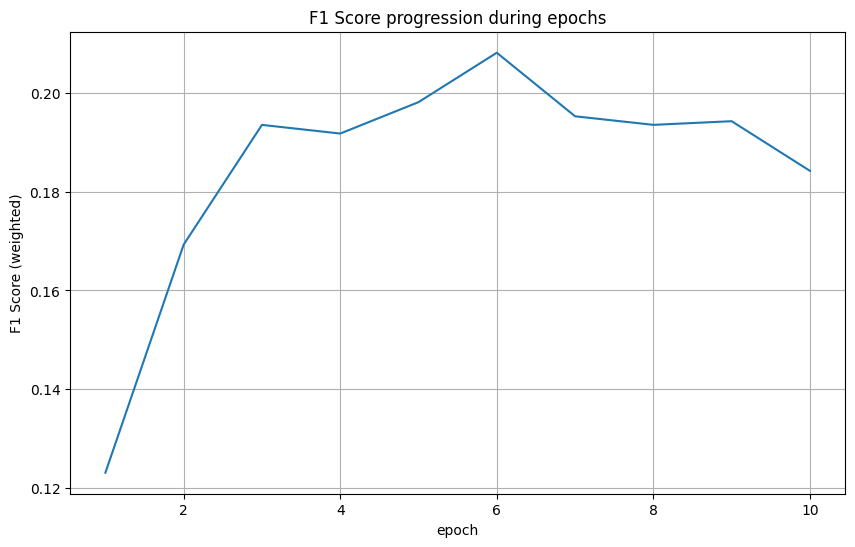

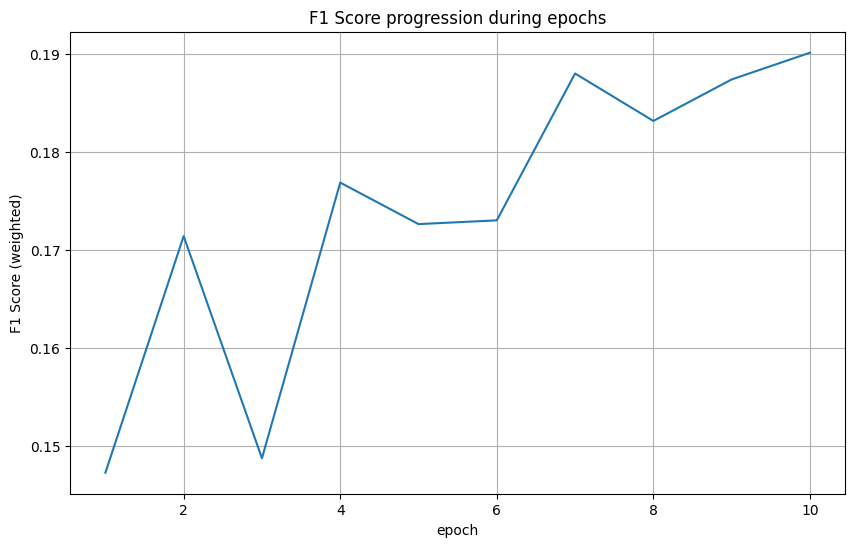

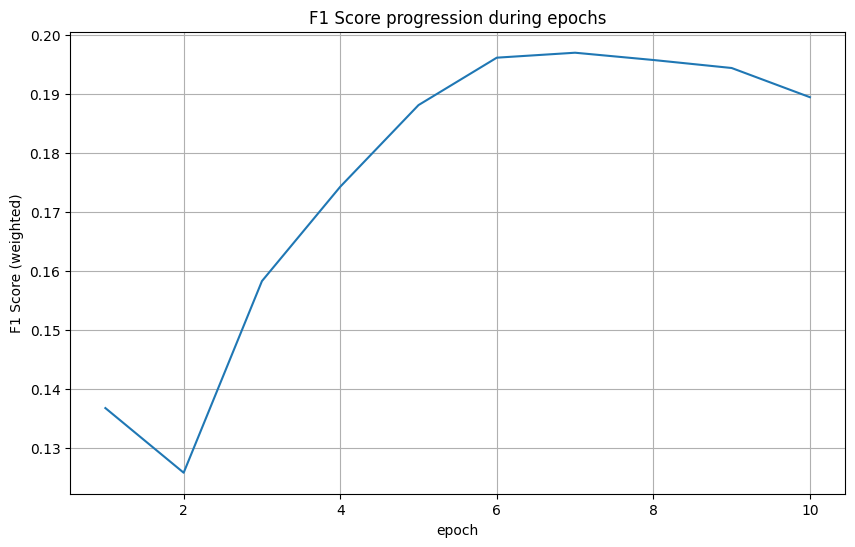

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


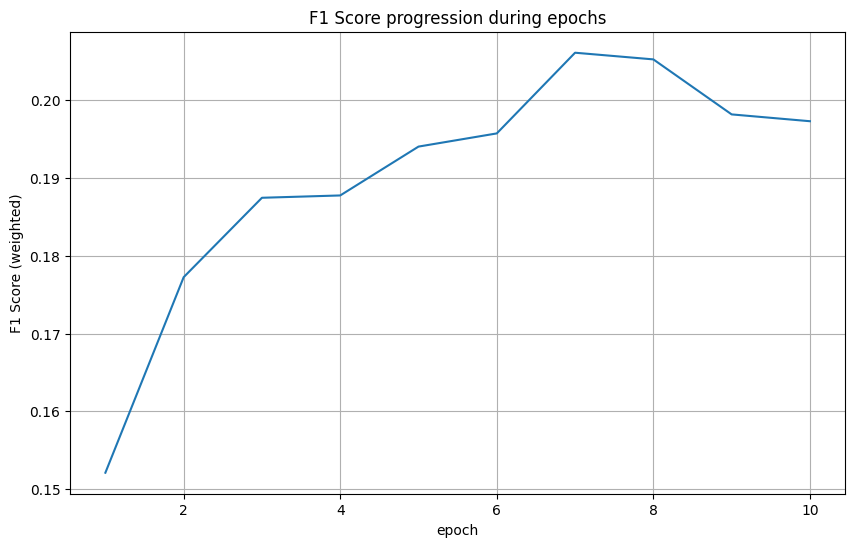

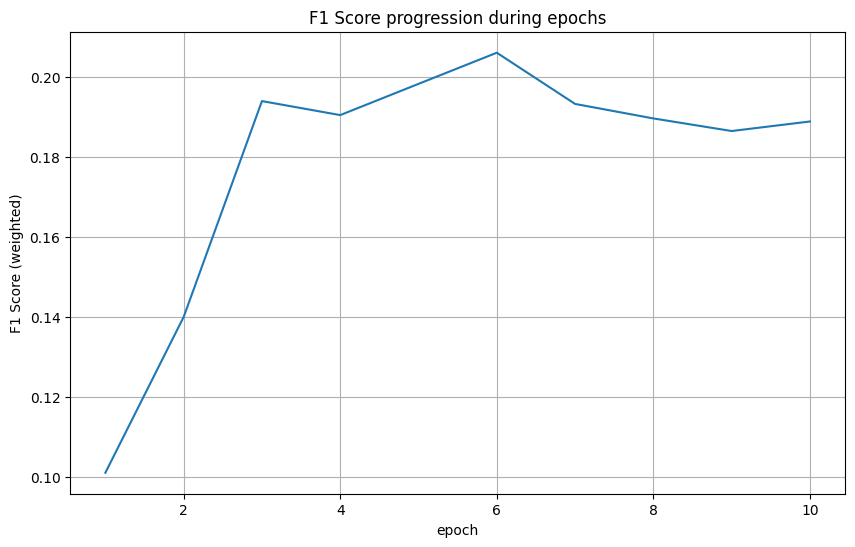

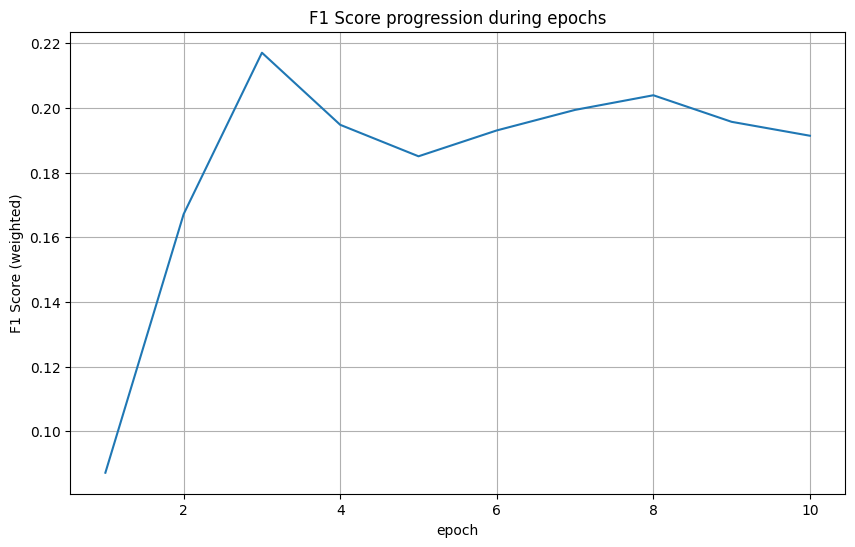

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


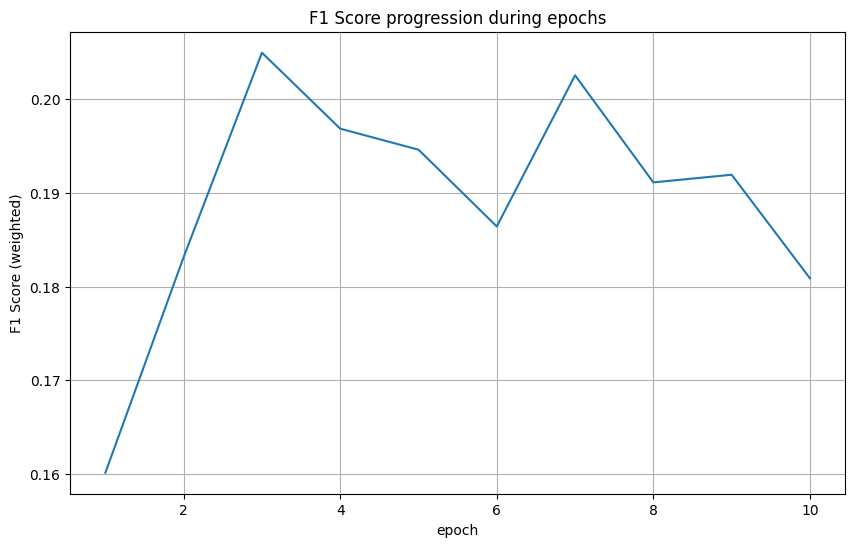

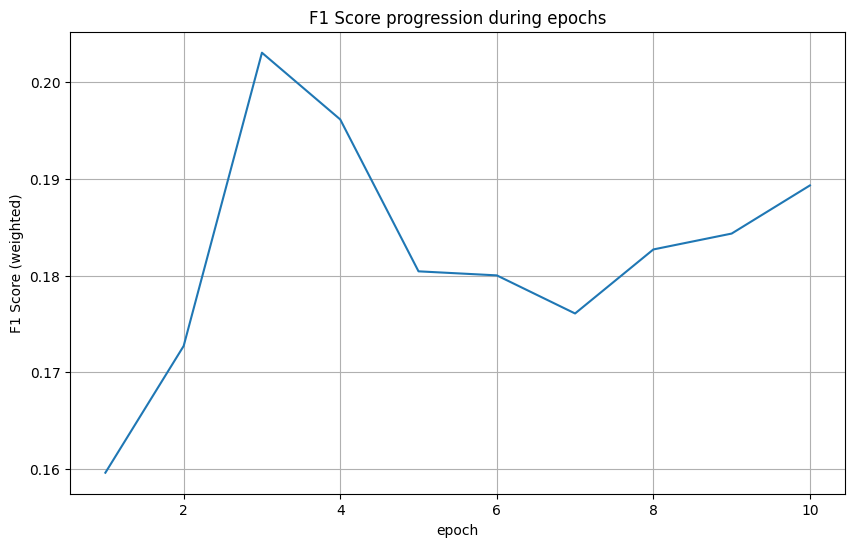

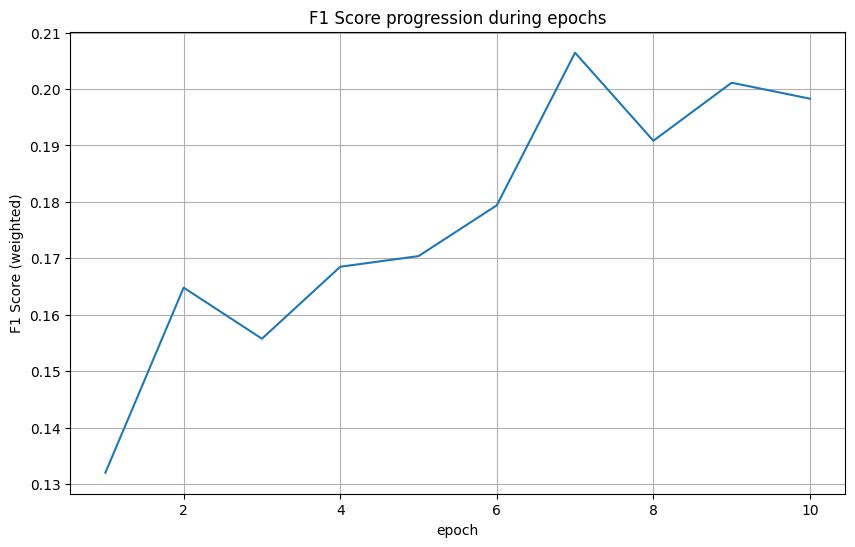

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


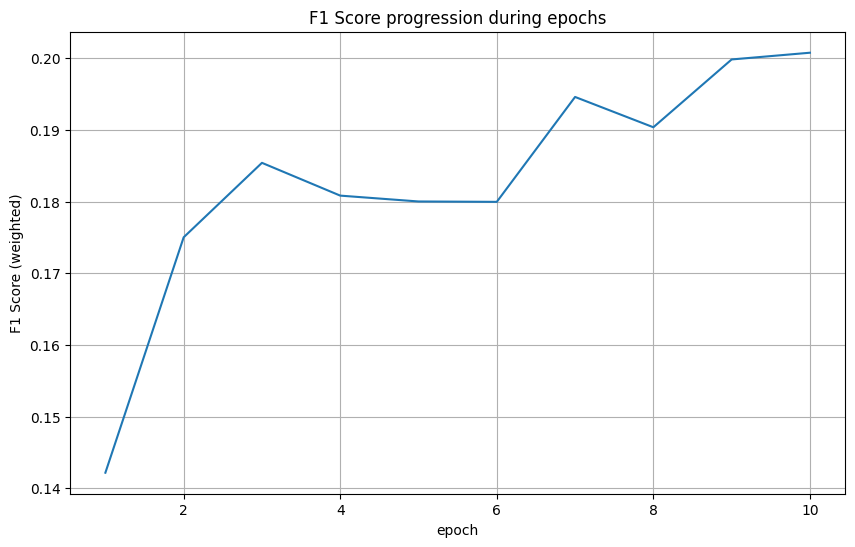

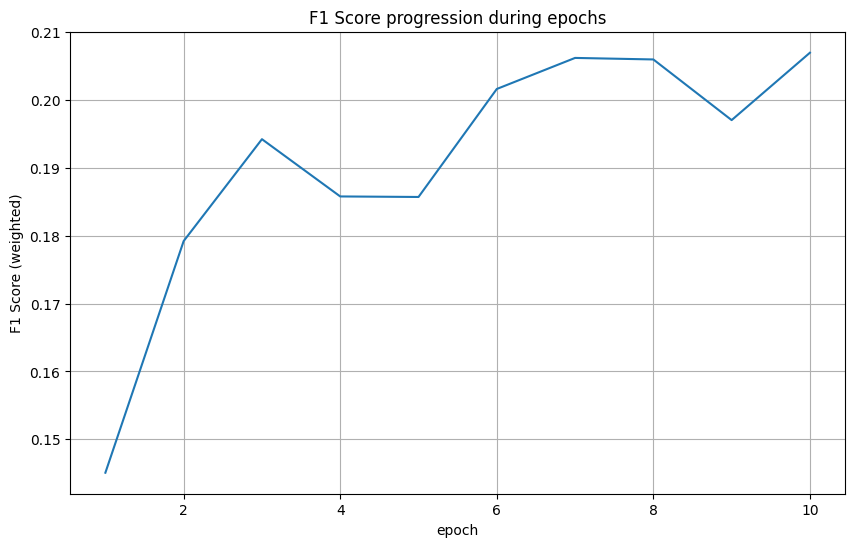

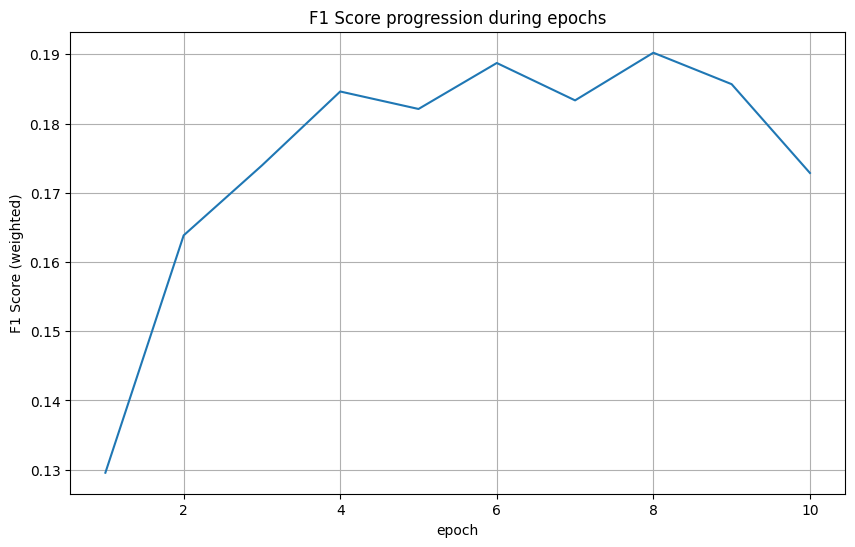

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


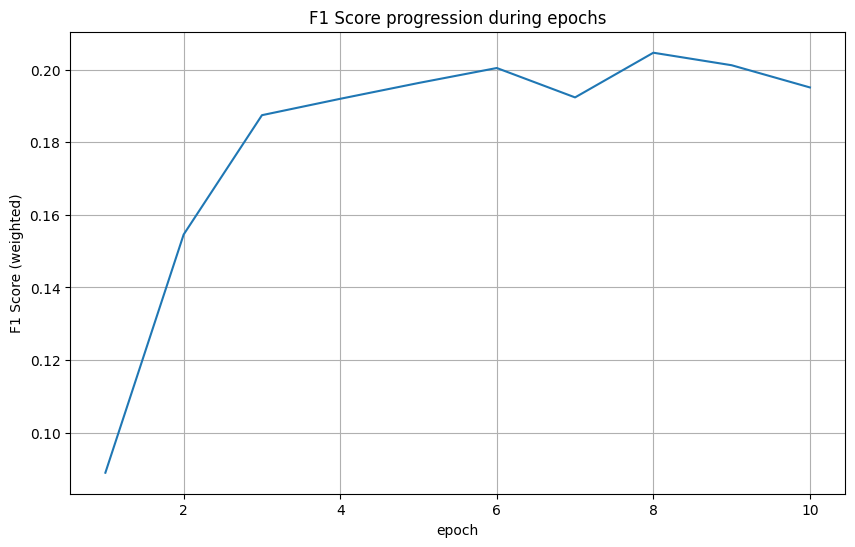

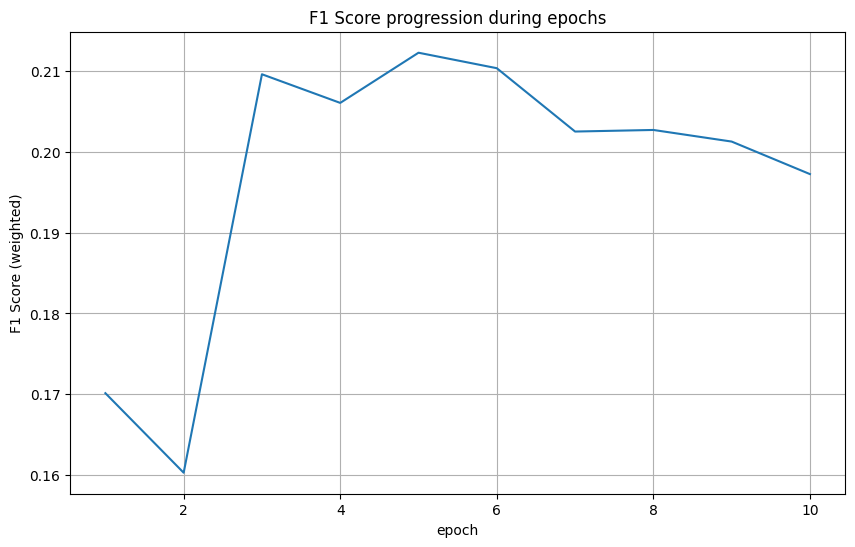

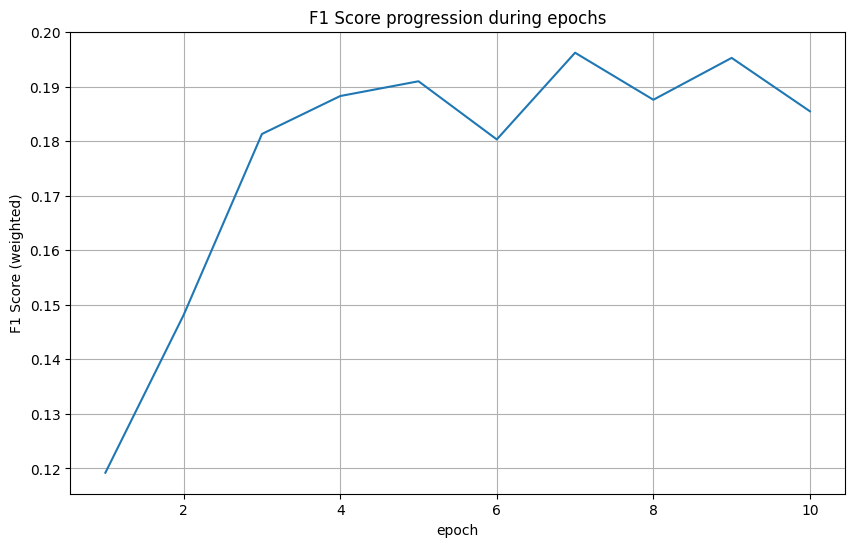

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


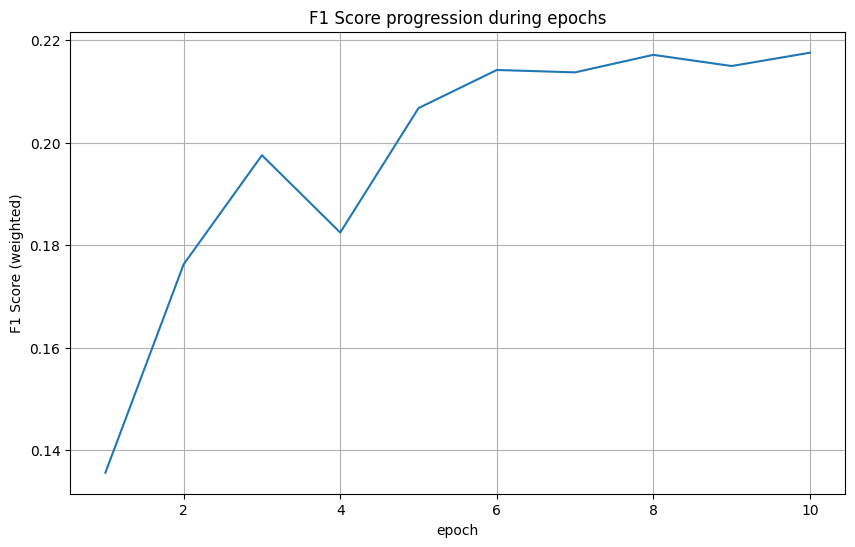

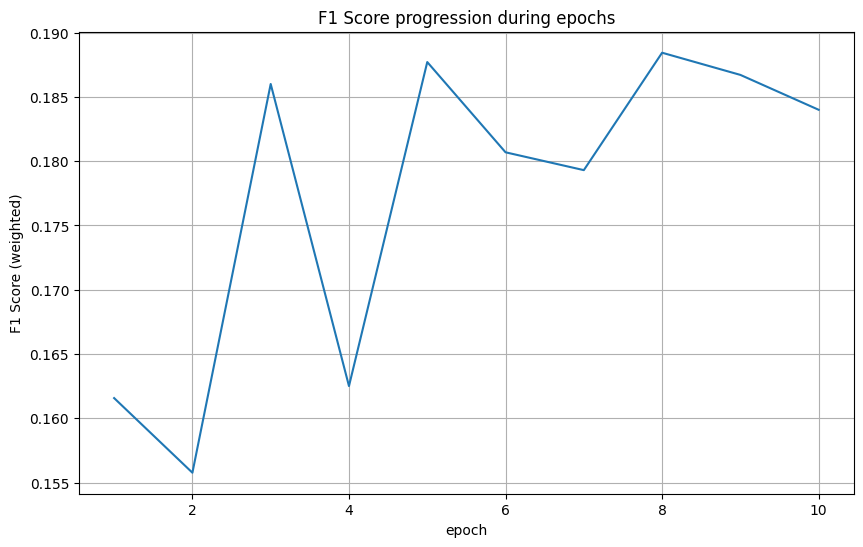

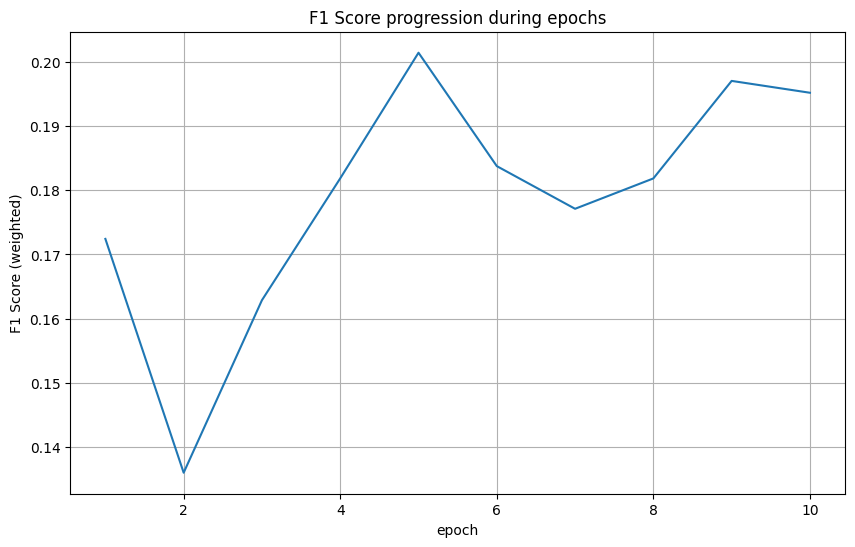

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


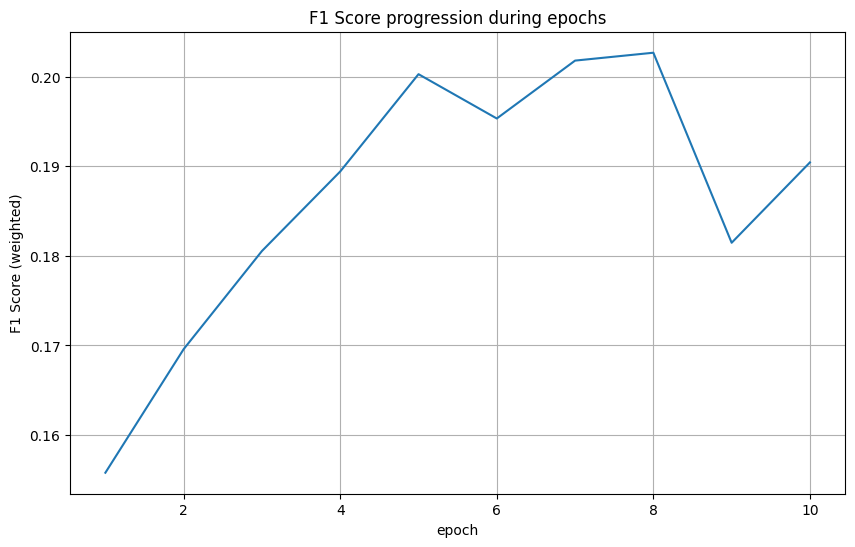

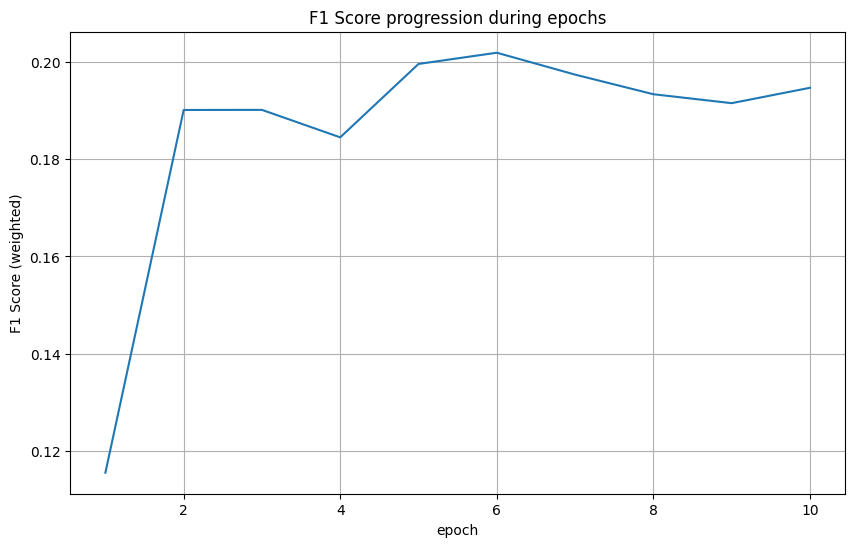

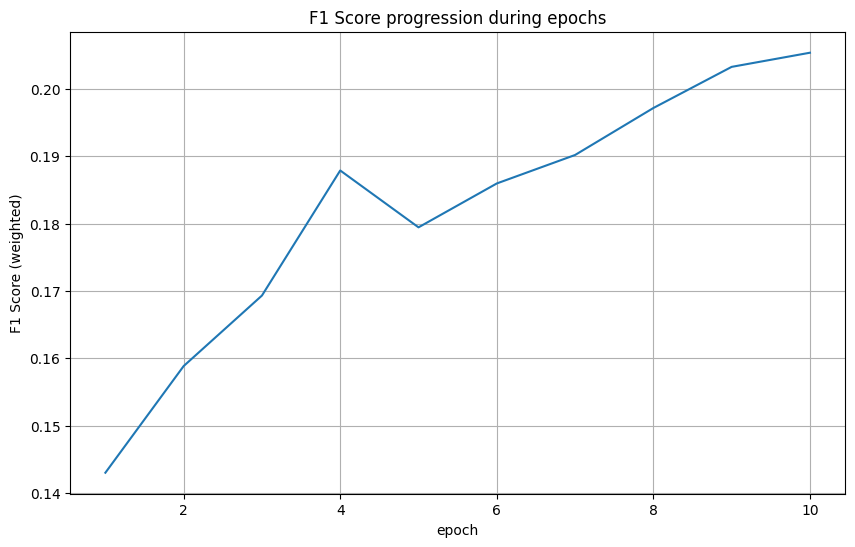

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


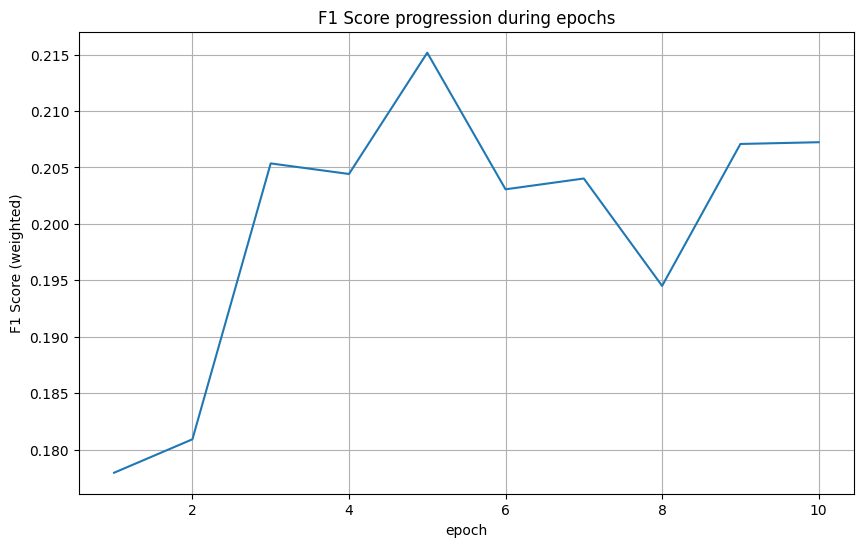

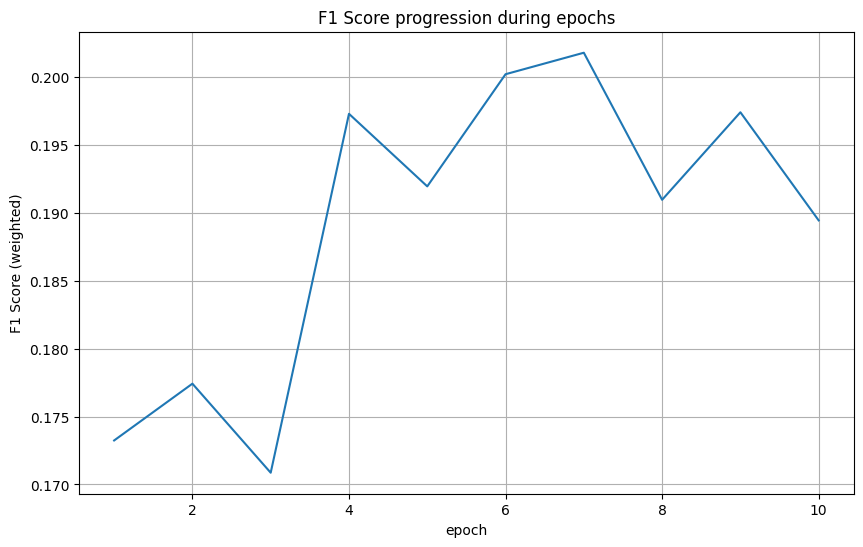

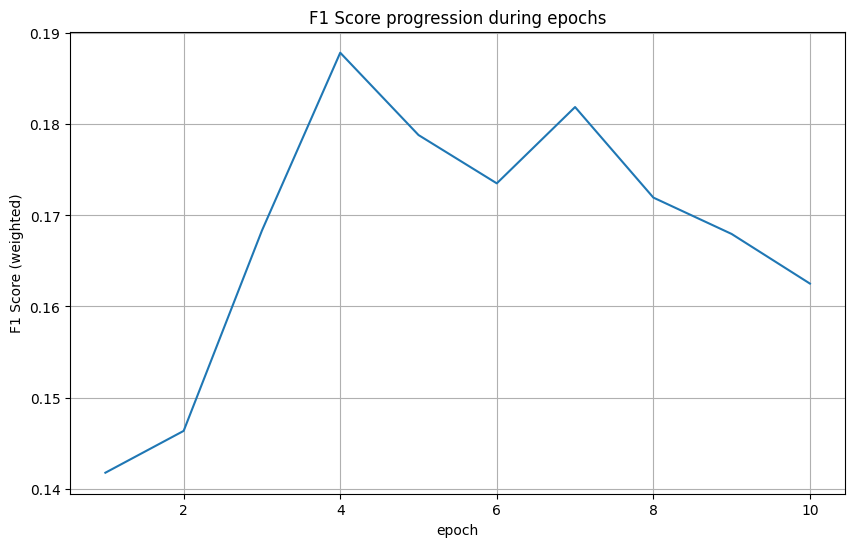

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


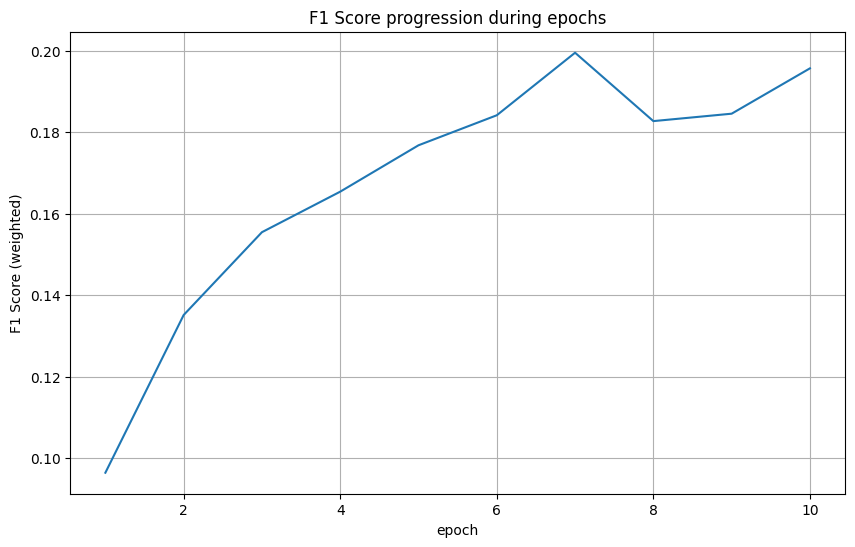

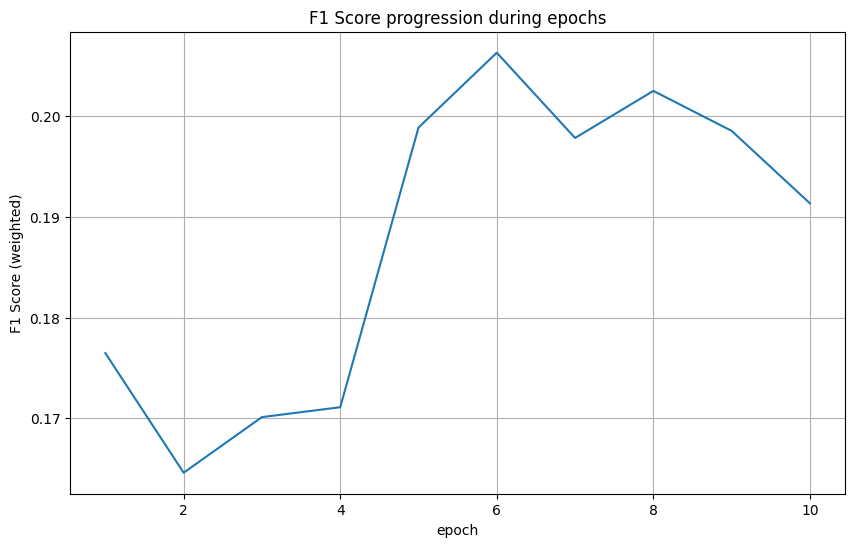

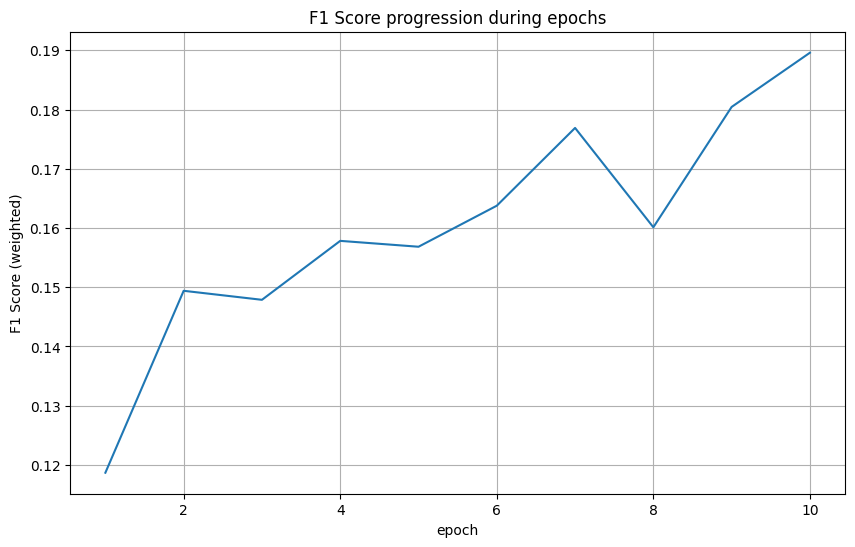

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


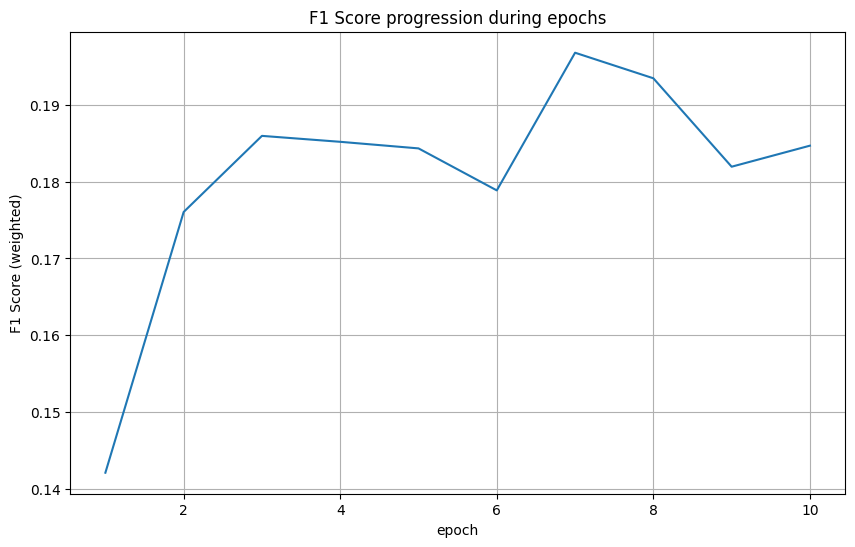

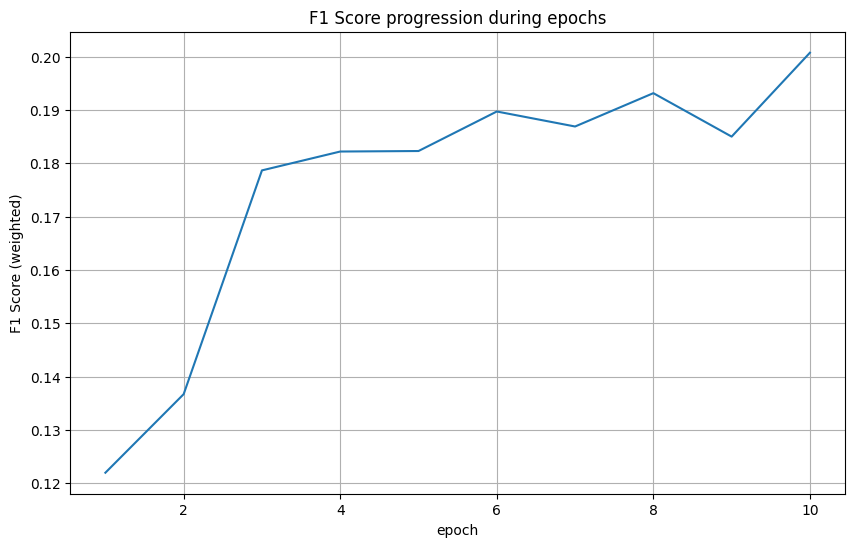

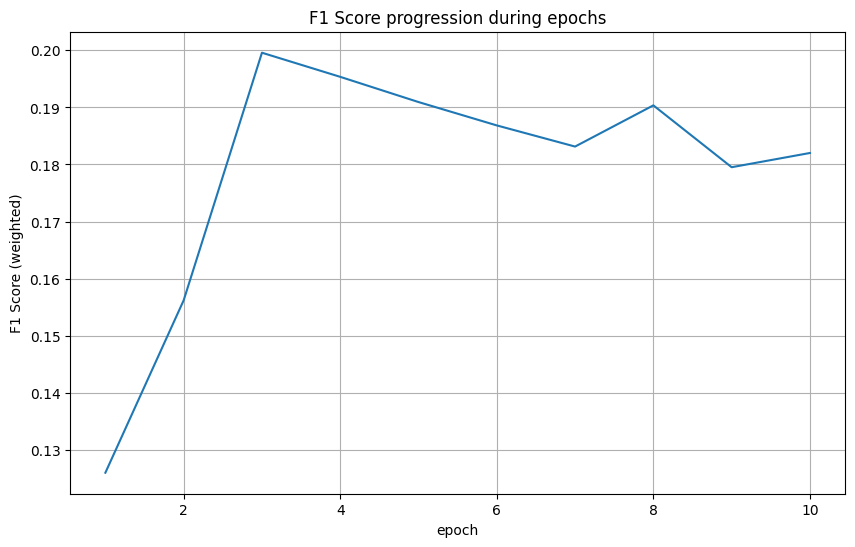

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


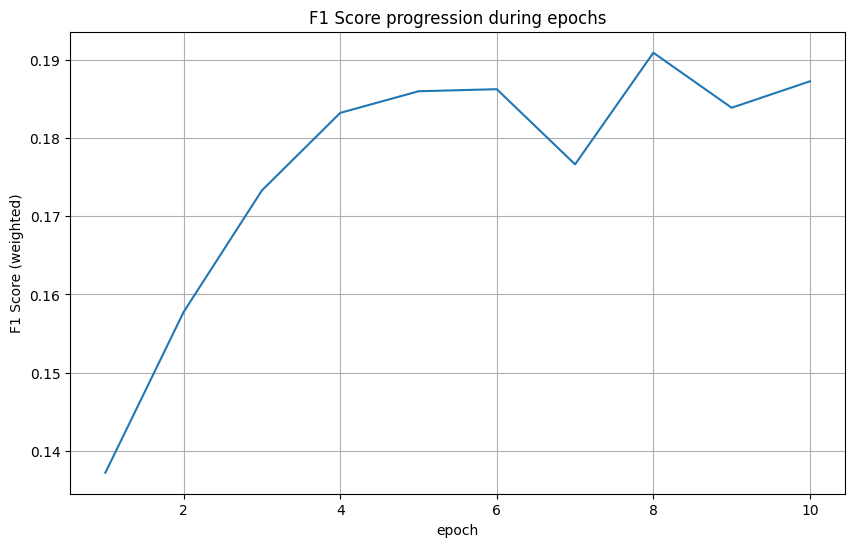

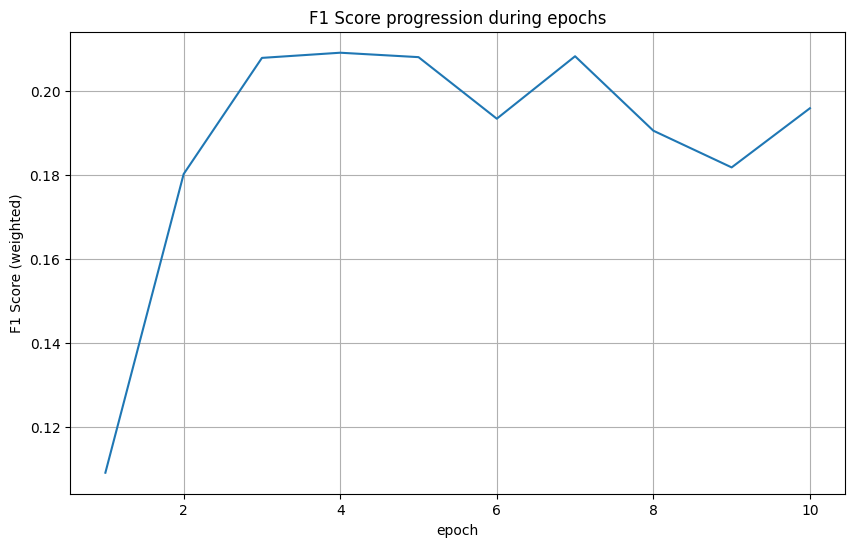

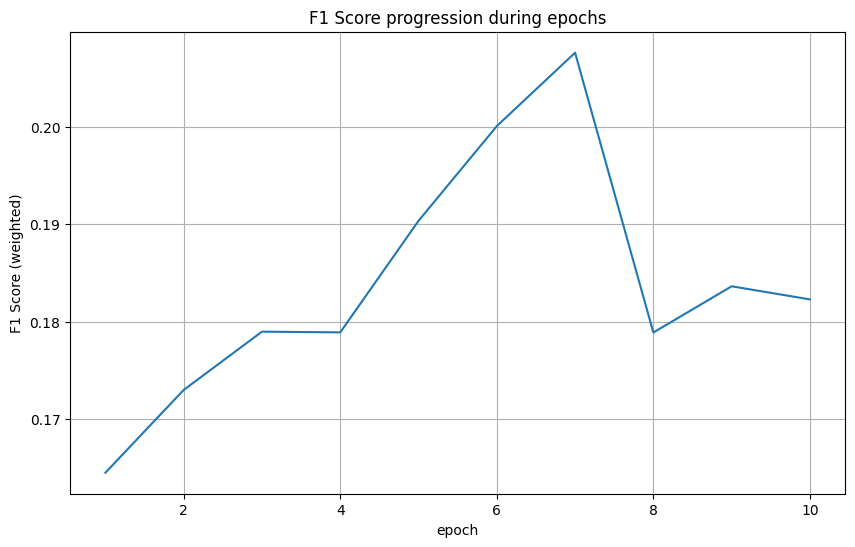

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


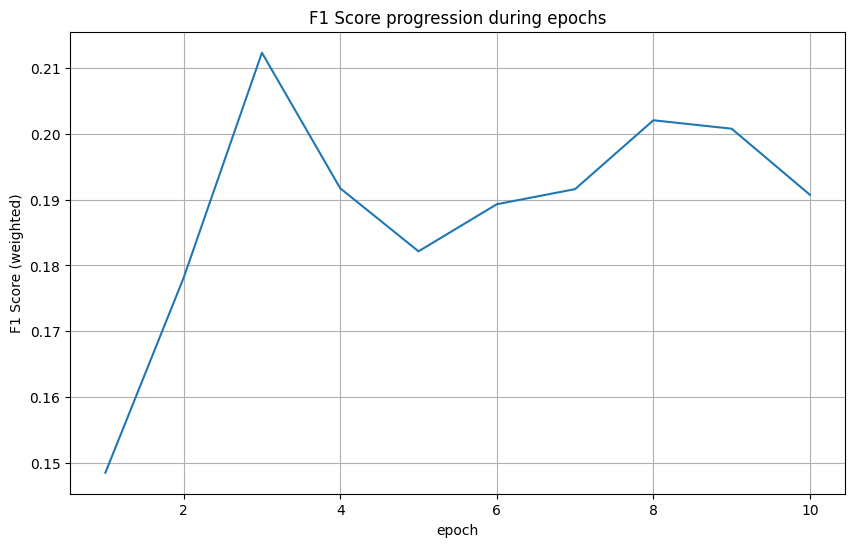

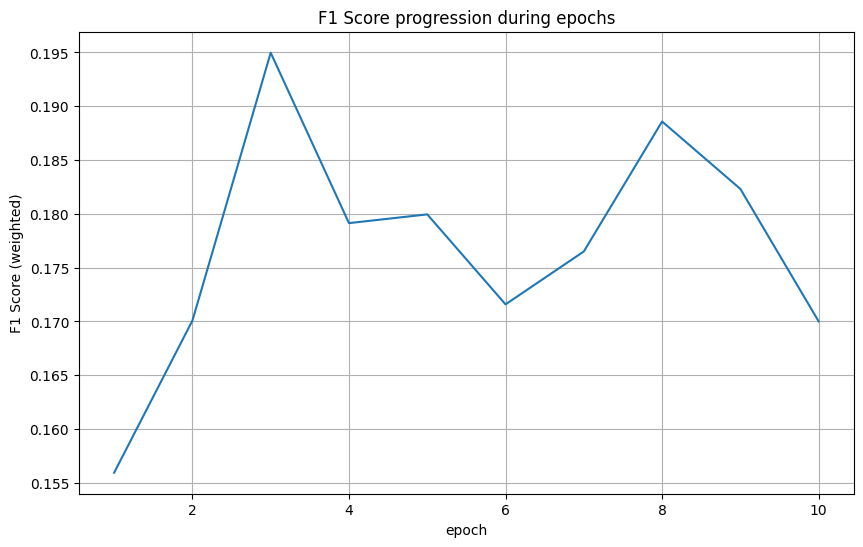

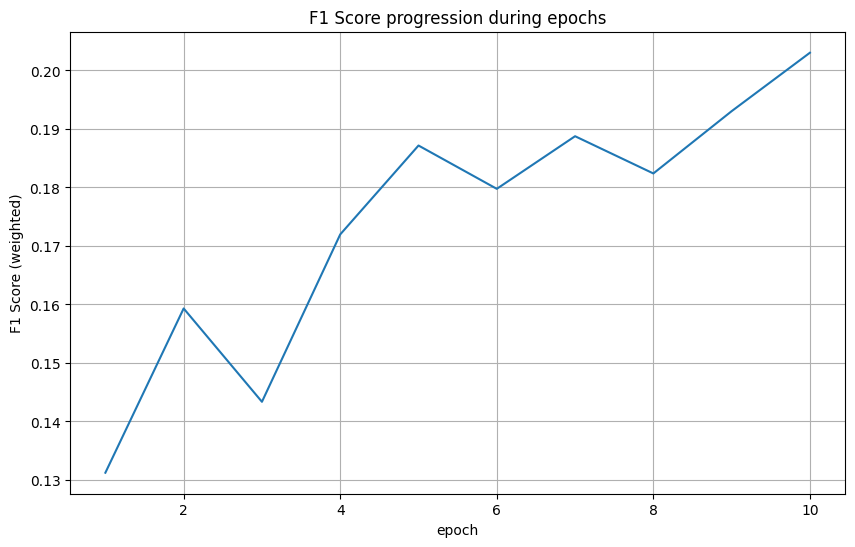

                                         model  hidden_size  n_layers  \
0   Baseline(predicting the most common class)          NaN       NaN   
1                                         LSTM         32.0       1.0   
2                                         LSTM         32.0       2.0   
3                                         LSTM         32.0       3.0   
4                                         LSTM         64.0       1.0   
5                                         LSTM         64.0       2.0   
6                                         LSTM         64.0       3.0   
7                                         LSTM         32.0       1.0   
8                                         LSTM         32.0       2.0   
9                                         LSTM         32.0       3.0   
10                                        LSTM         64.0       1.0   
11                                        LSTM         64.0       2.0   
12                                        LSTM     

In [76]:
true_labels = test['label'].values
word_vector_sizes = [32, 64]
hidden_sizes = [32, 64]
n_layers_list = [1, 2, 3]
dropouts = [0.2, 0.5, 0.8]
for dropout in dropouts:
  for size in word_vector_sizes:
      for hidden_size in hidden_sizes:
          for layers in n_layers_list:
            model = Net(vocab_size=vocab_size, word_vector_size=size, hidden_size=hidden_size, n_layers=layers, dropout = dropout)
            predictions = train_model(model)
            accuracy = accuracy_score(true_labels, predictions)
            precision = precision_score(true_labels, predictions, average='weighted')
            recall = recall_score(true_labels, predictions, average='weighted')
            f1 = f1_score(true_labels, predictions, average='weighted')
            append_results(report, model, accuracy, precision, recall, f1)
print(pd.DataFrame(report))

Not great results, we should try to vectorize the words in a different way

In [77]:
train = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/test.csv")
valid = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/valid.csv")
X_train_np, vocab_size = simple_tokenizer(train['statement'], max_len = 30)
X_valid_np, _ = simple_tokenizer(valid['statement'], max_len = 30)
X_test_np, _ = simple_tokenizer(test['statement'], max_len = 30)
train_loader = DataLoader(to_tensor(X_train_np, train['label']), batch_size=32, shuffle=True)
valid_loader = DataLoader(to_tensor(X_valid_np, valid['label']), batch_size=32)
test_loader = DataLoader(to_tensor(X_test_np, test['label']), batch_size=32)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


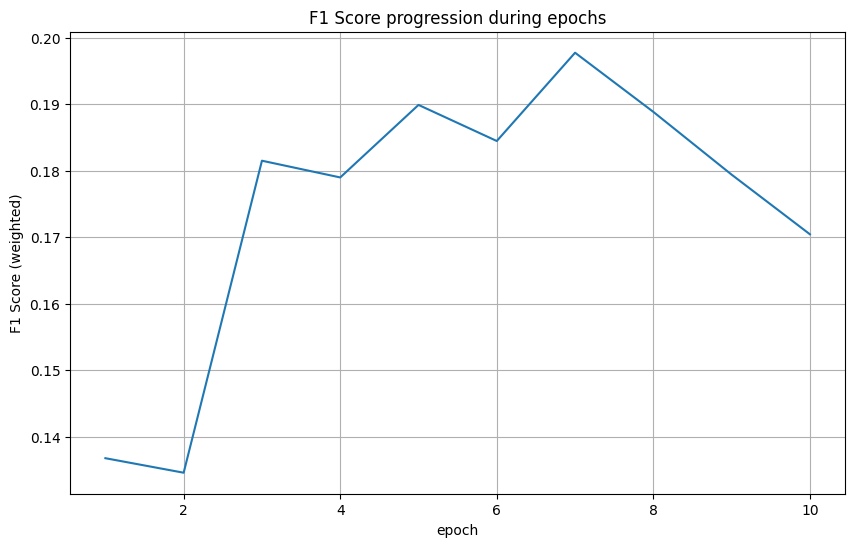

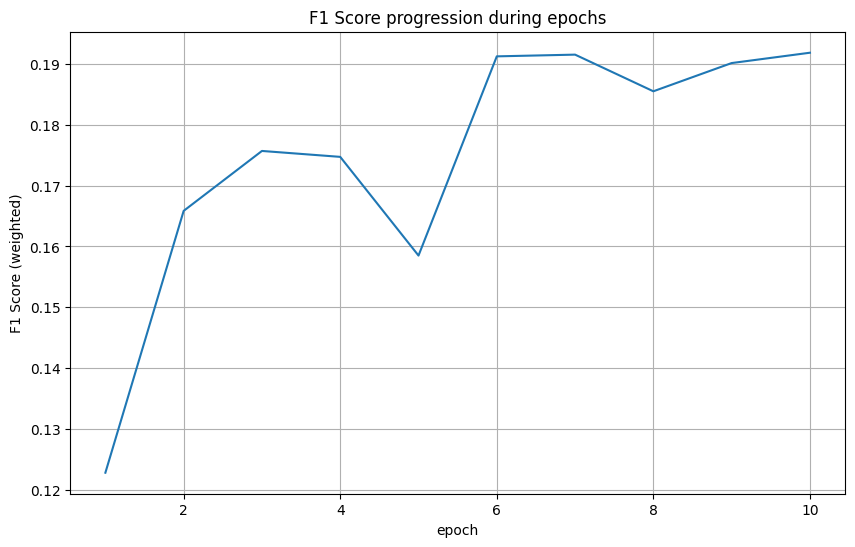

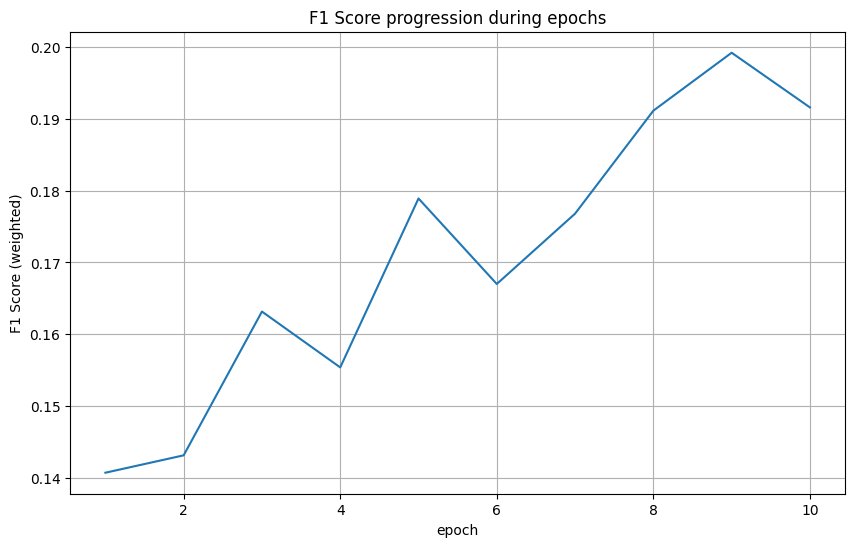

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


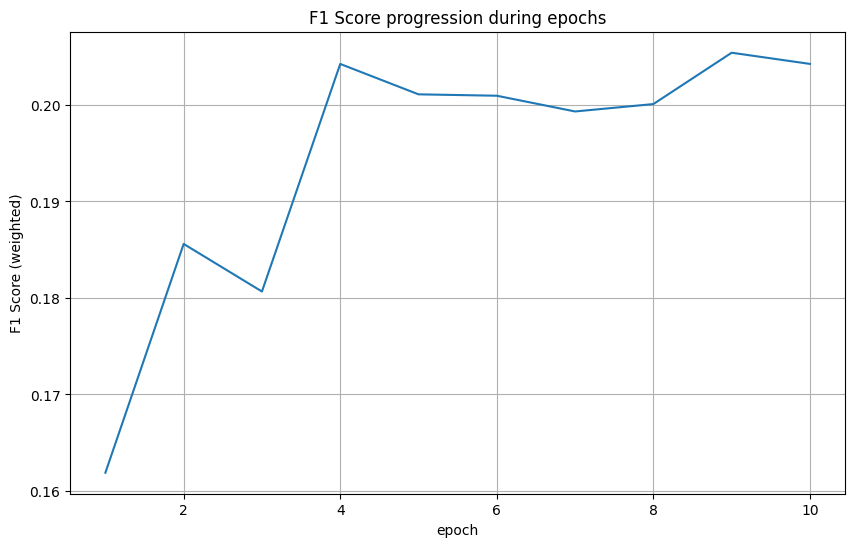

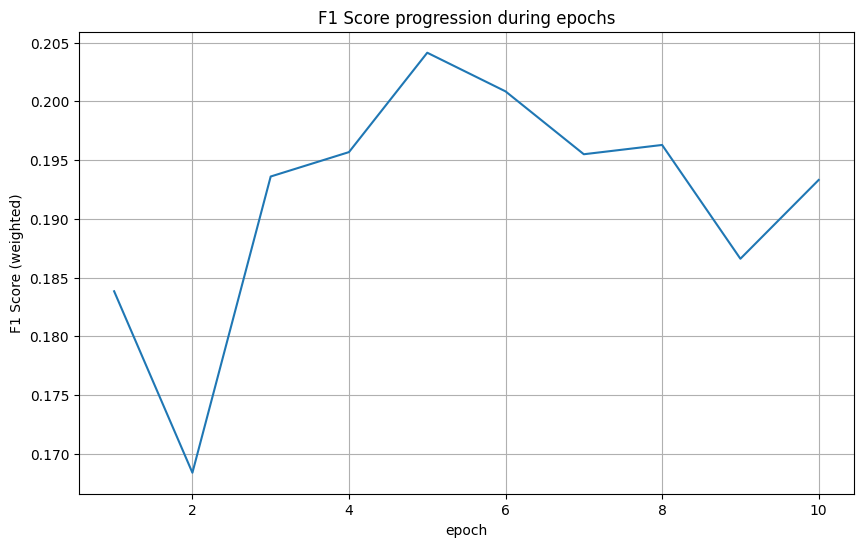

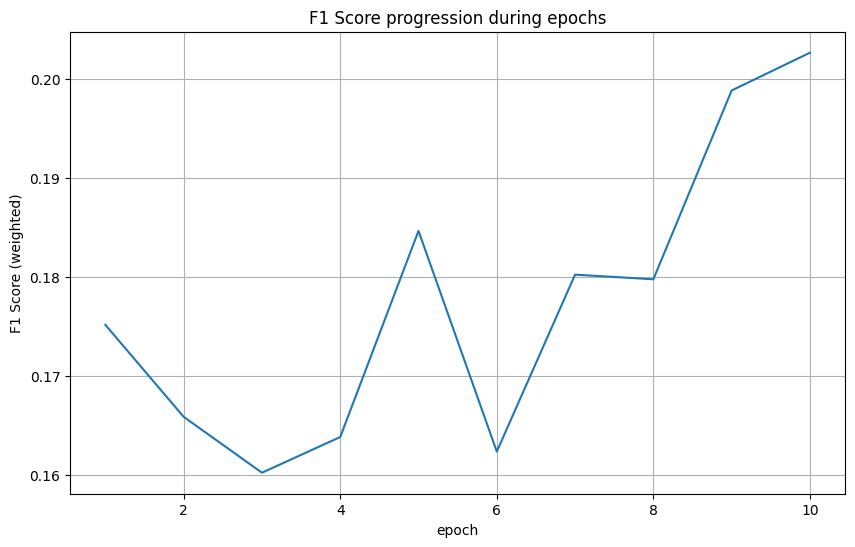

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


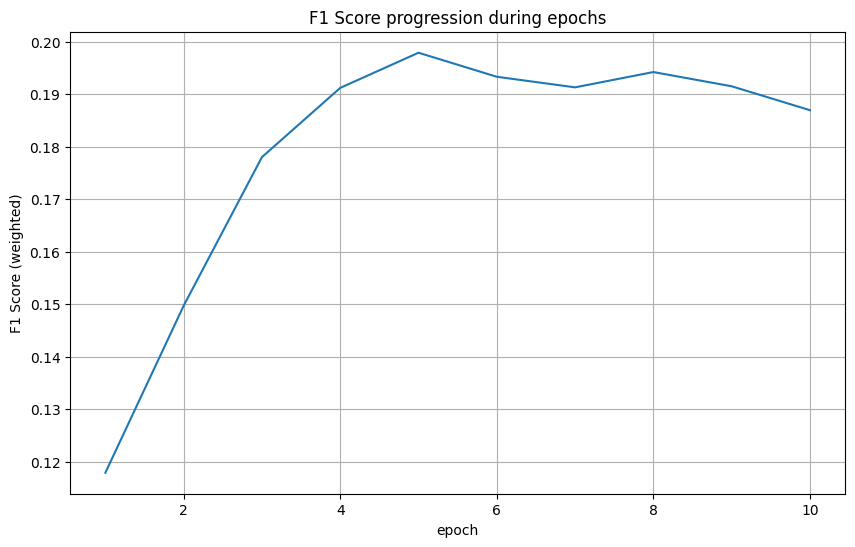

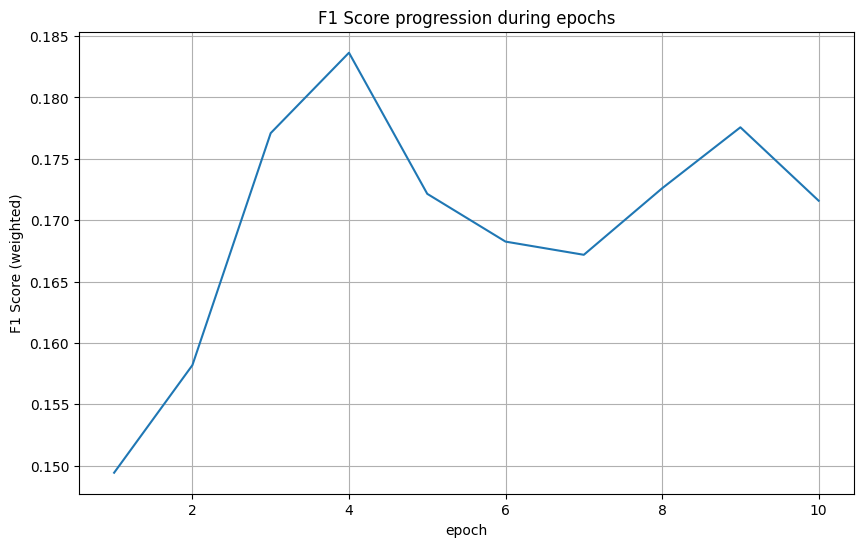

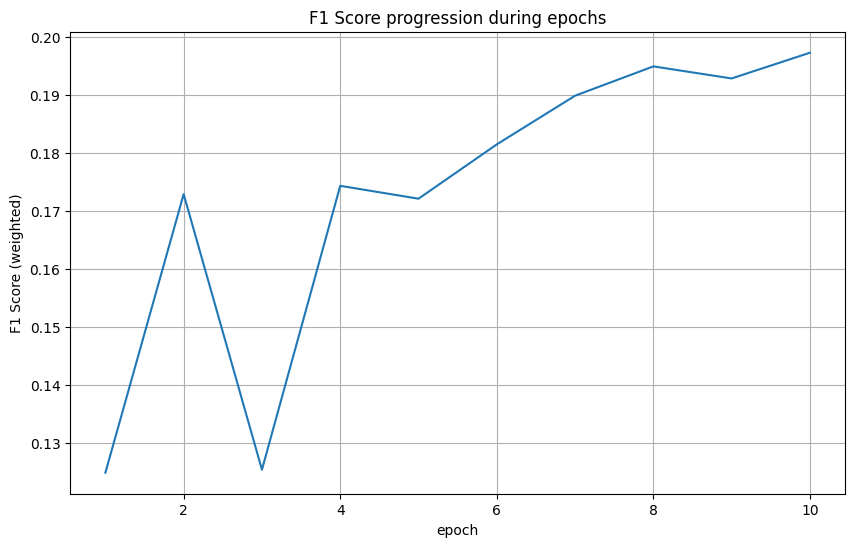

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


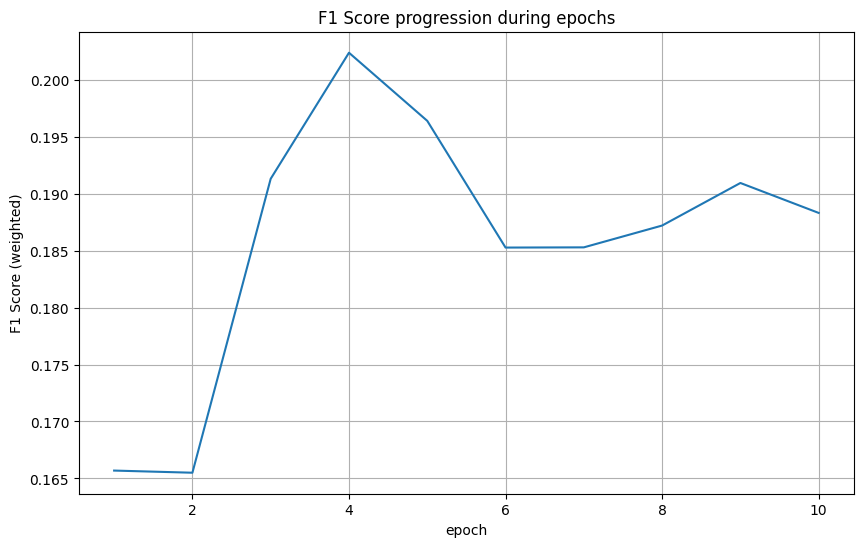

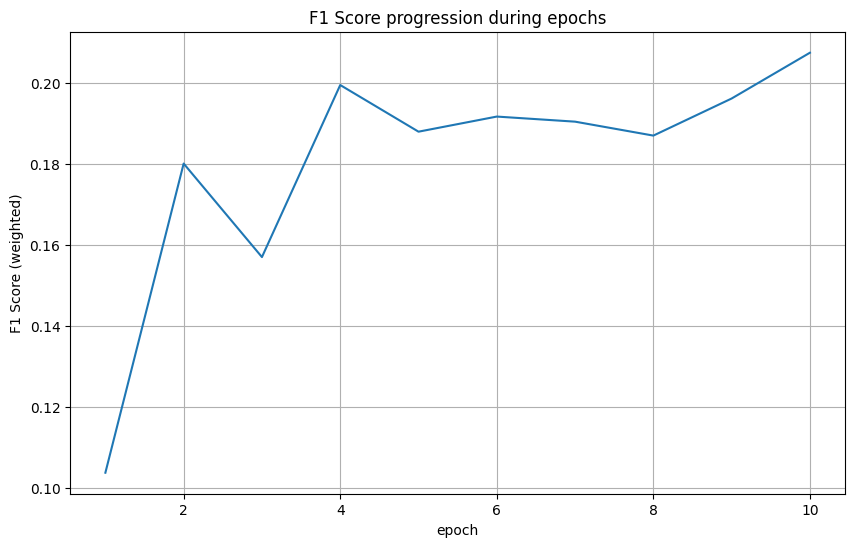

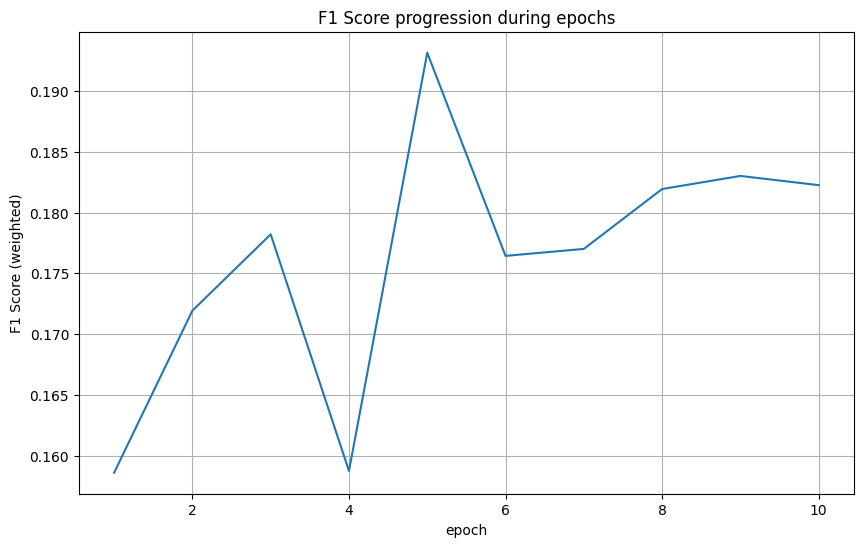

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


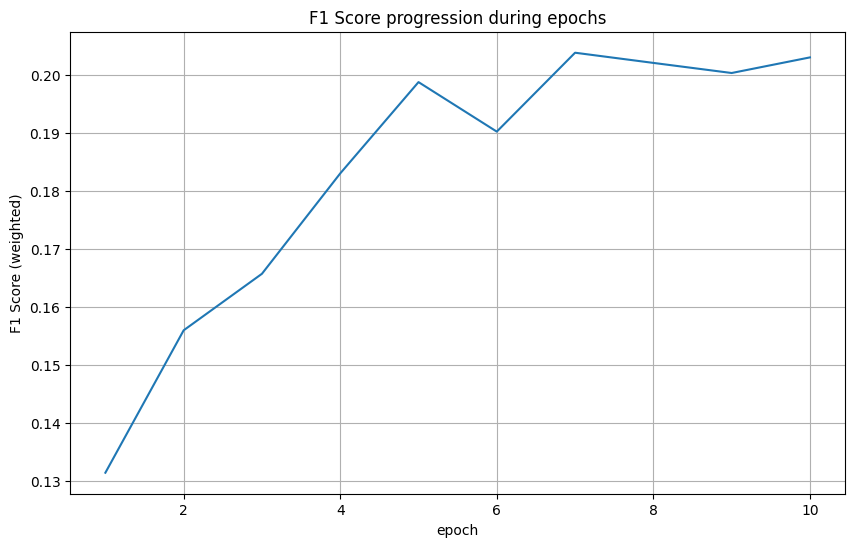

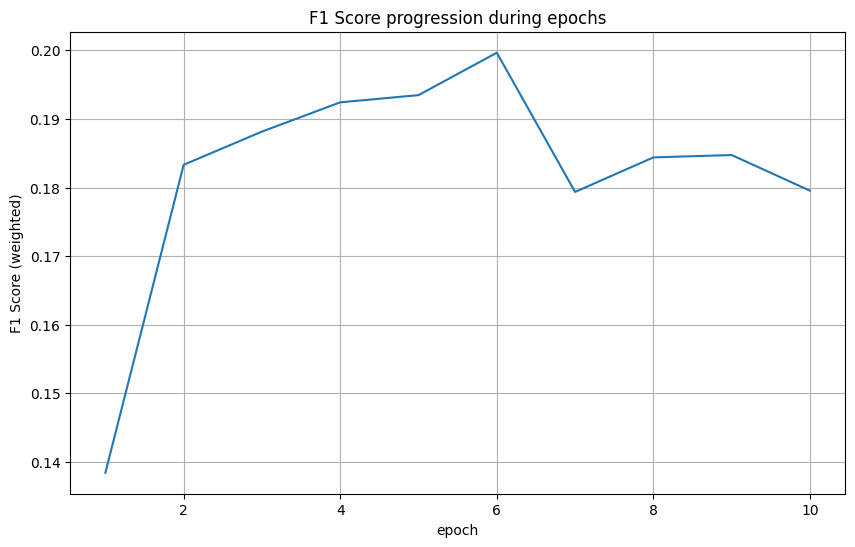

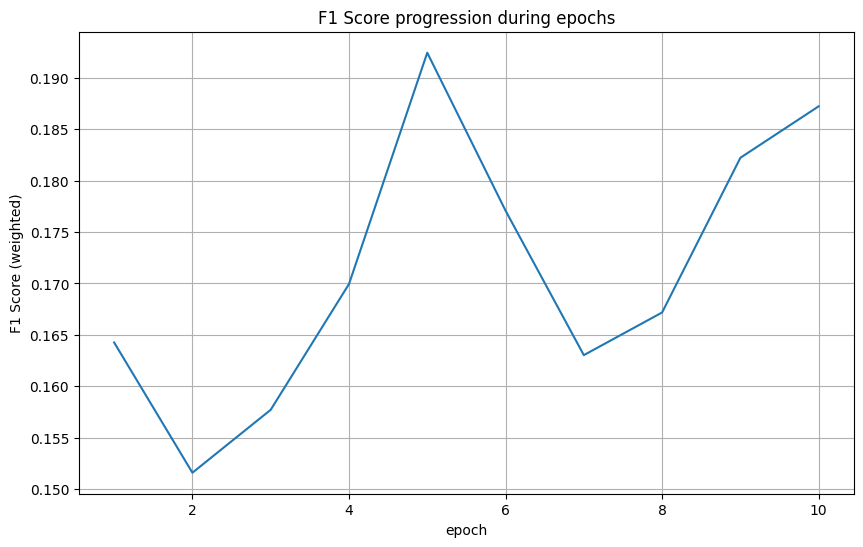

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


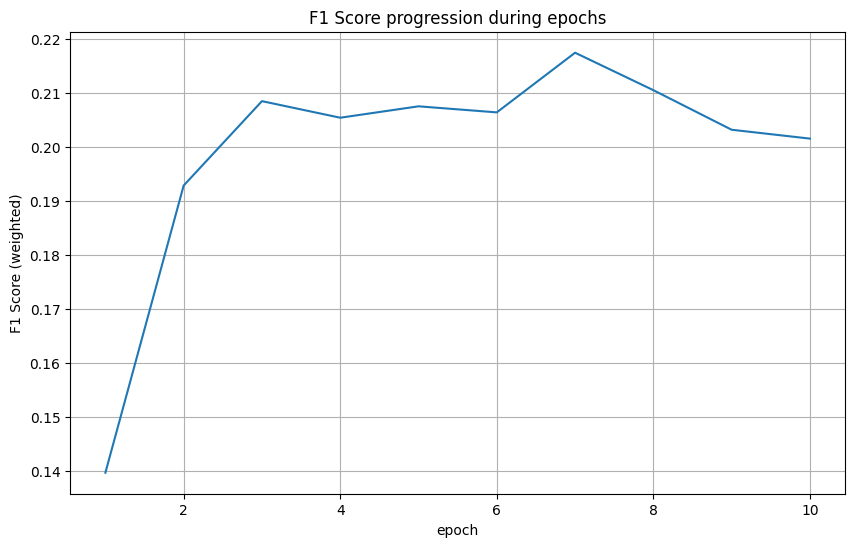

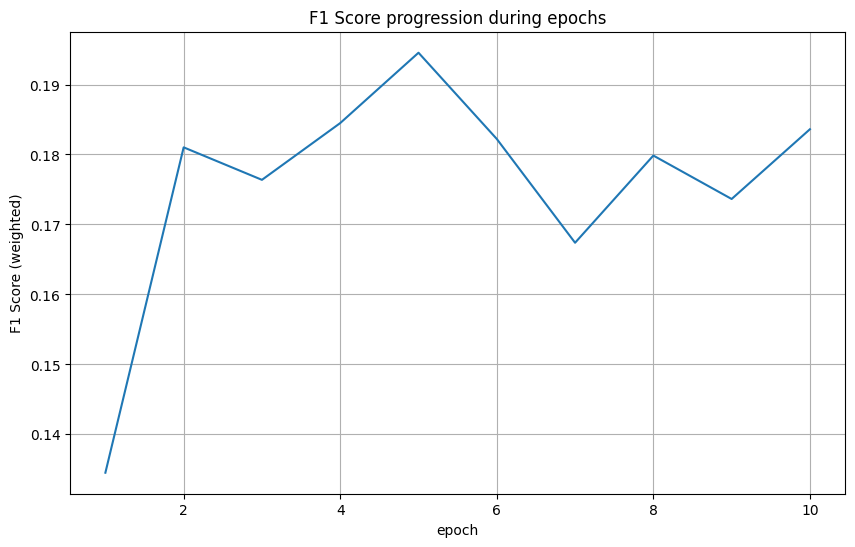

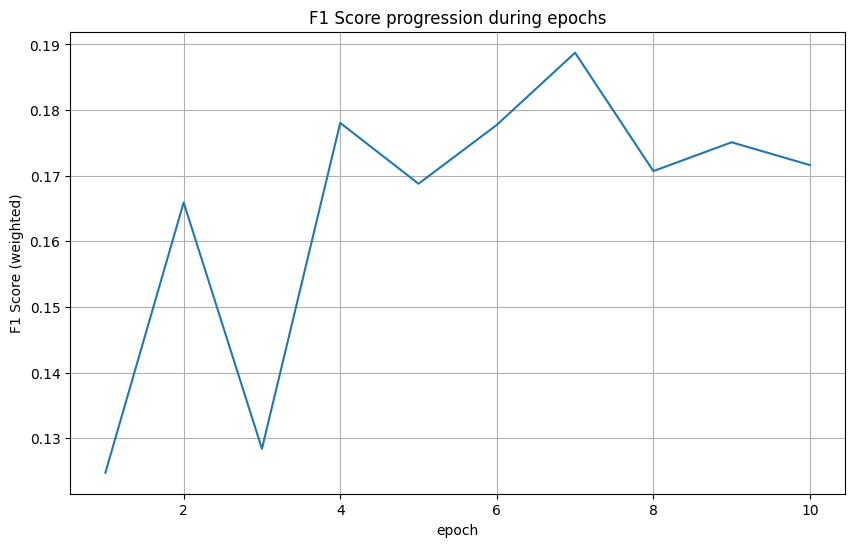

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


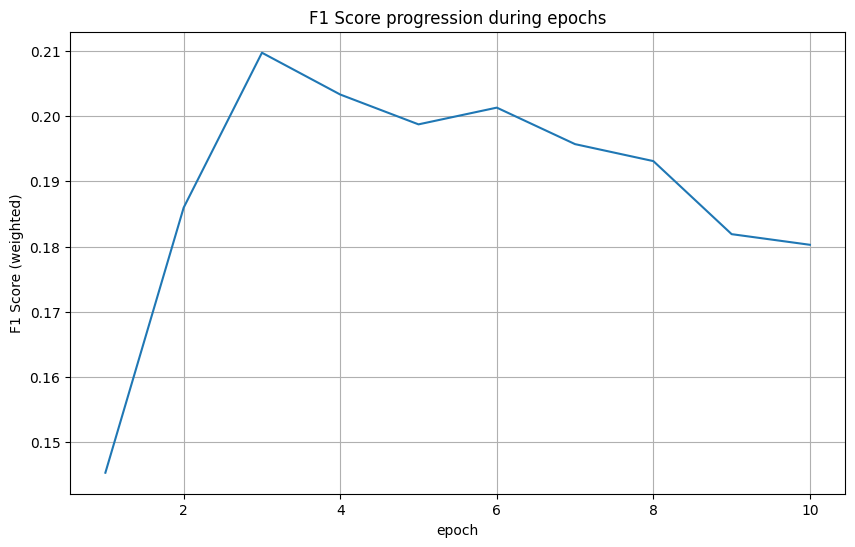

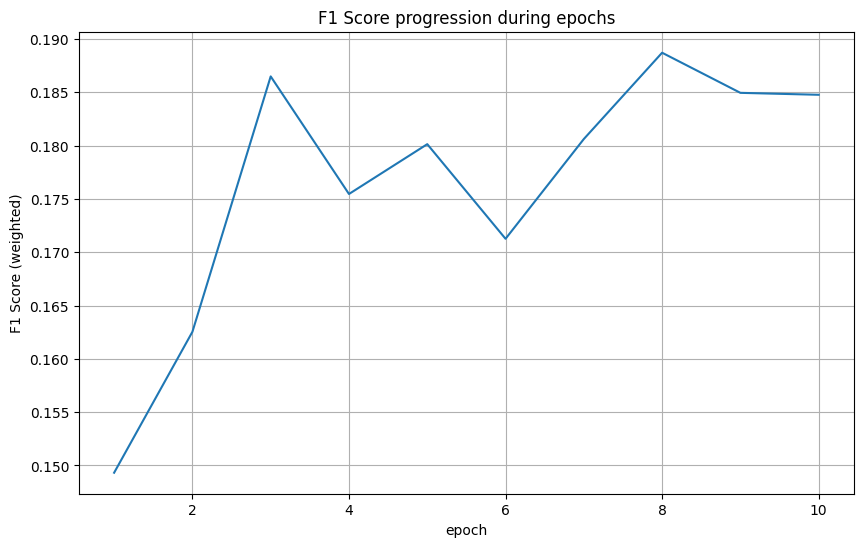

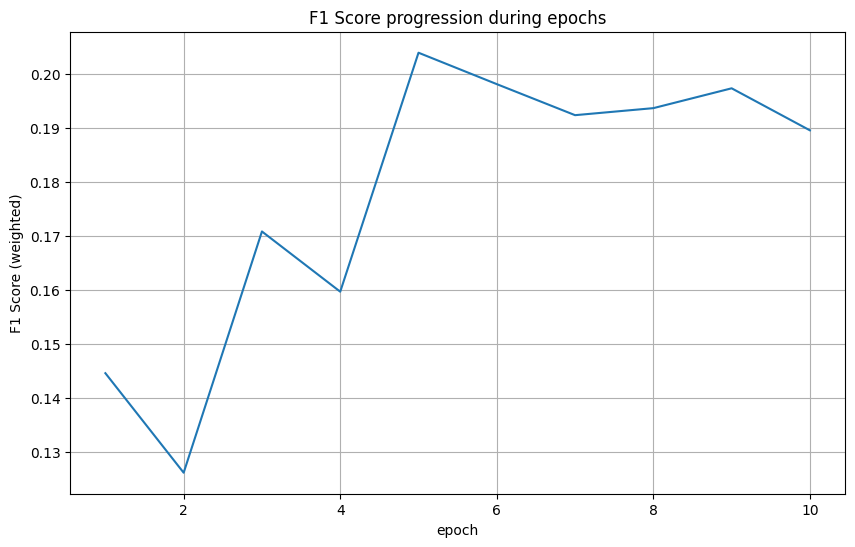

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


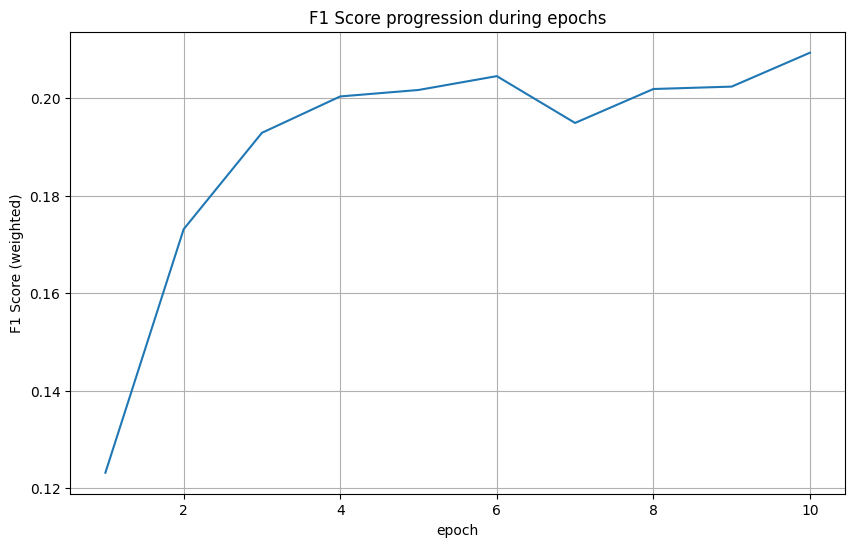

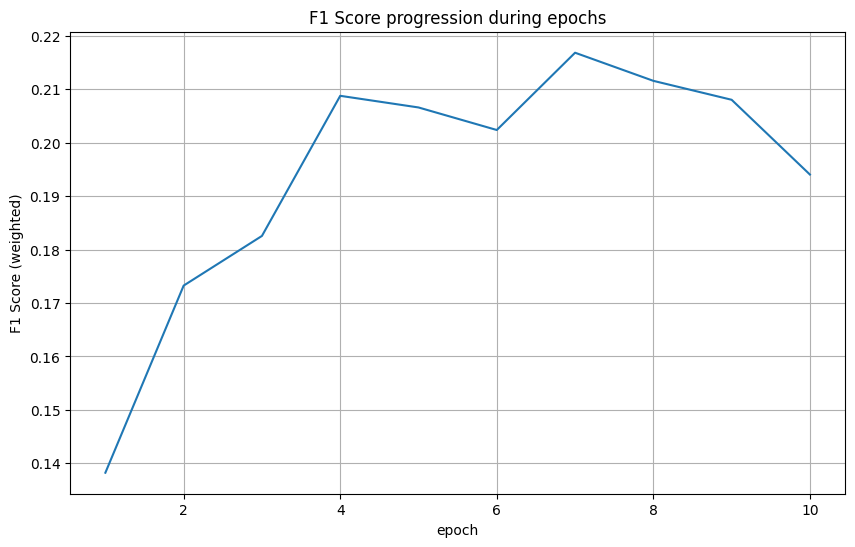

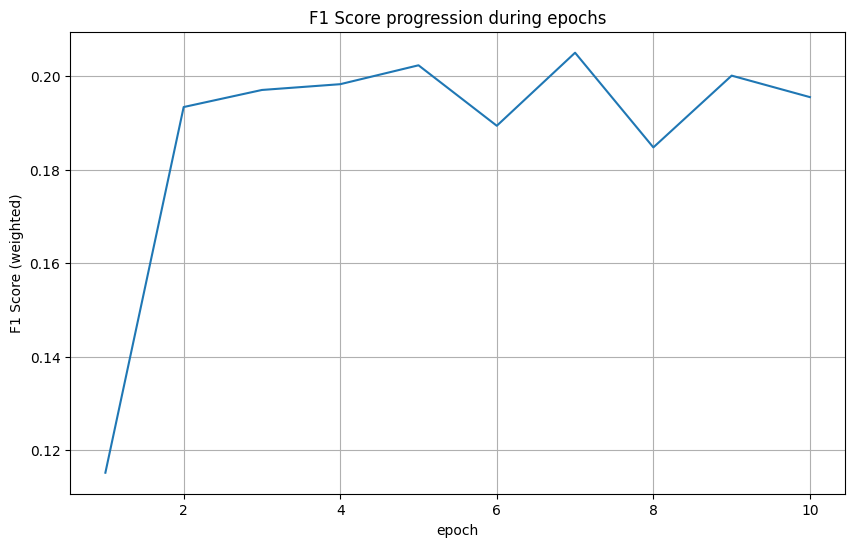

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


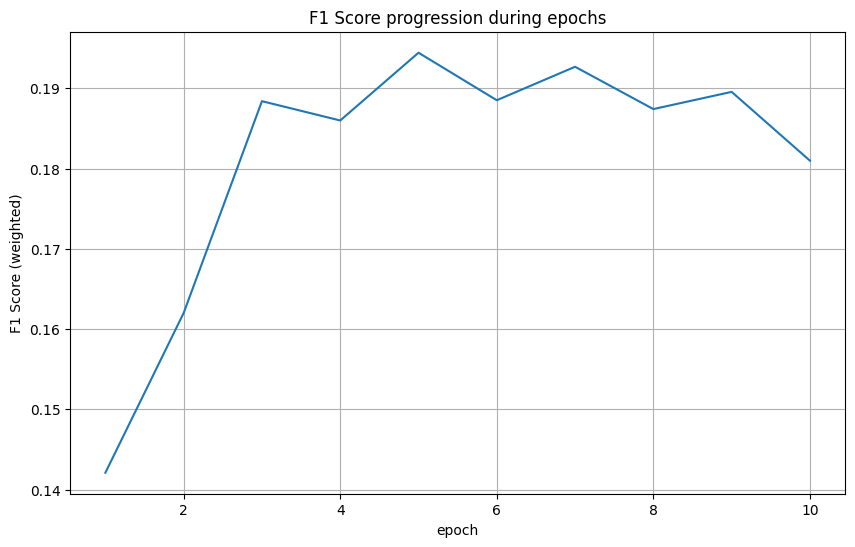

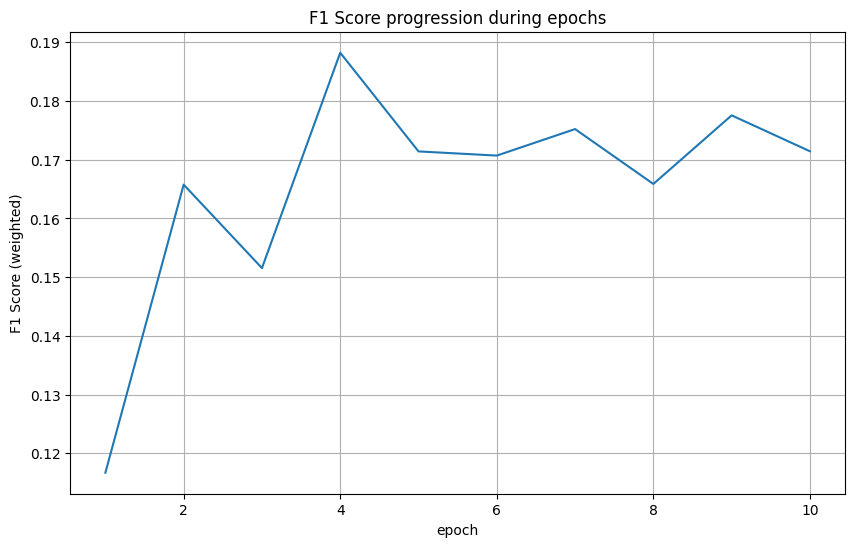

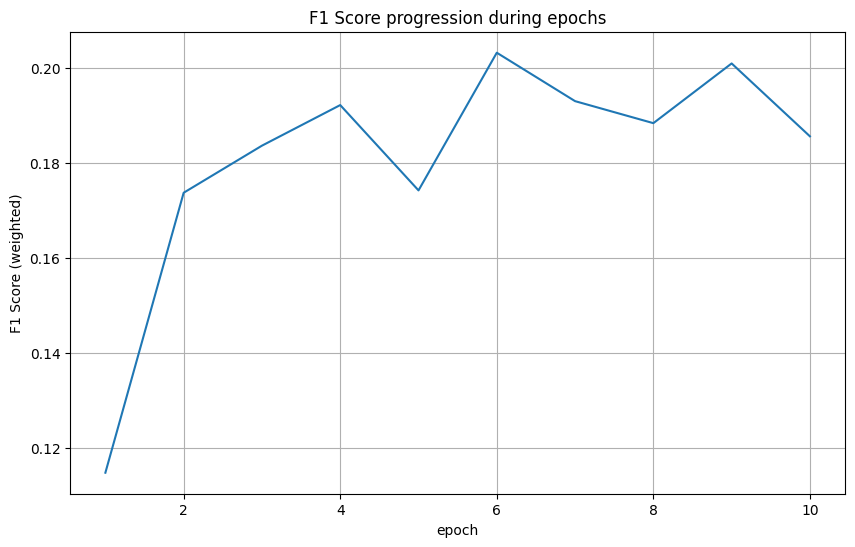

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


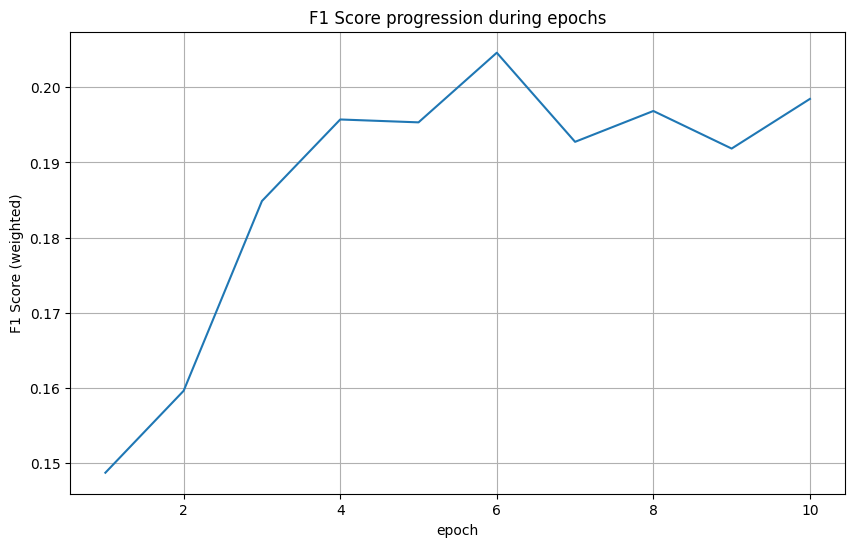

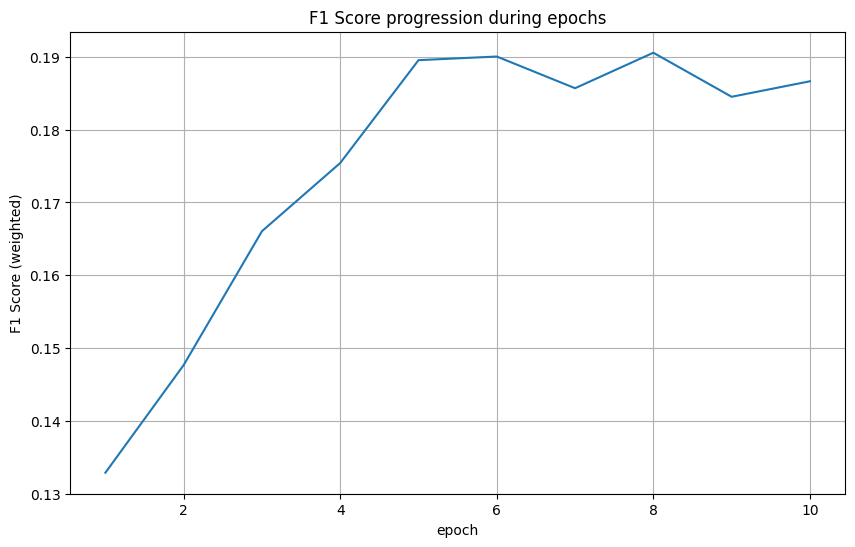

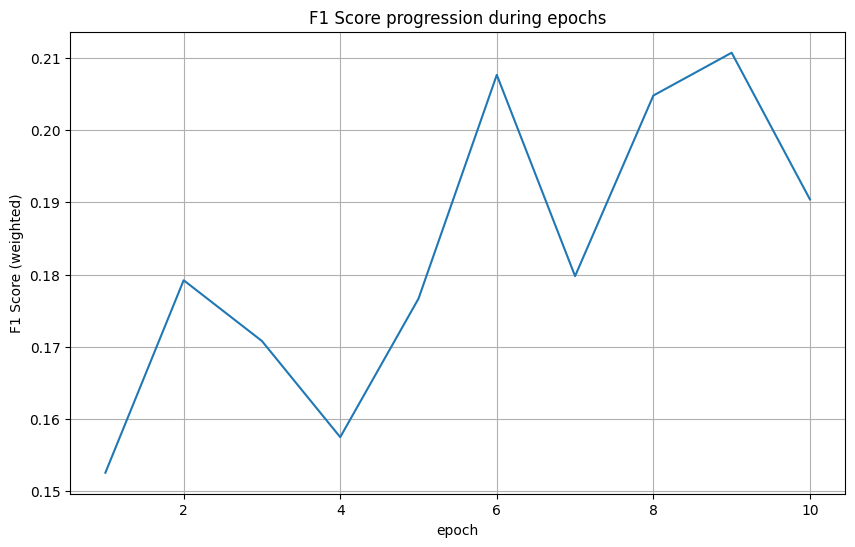

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


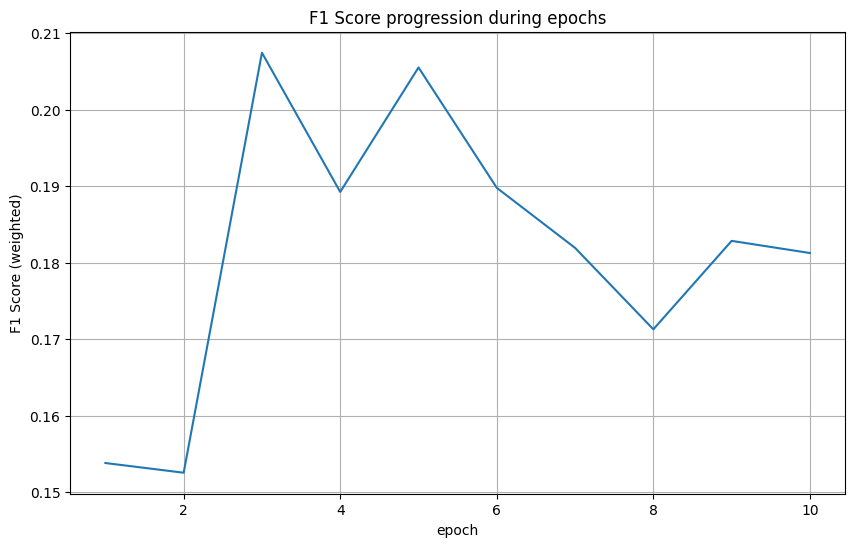

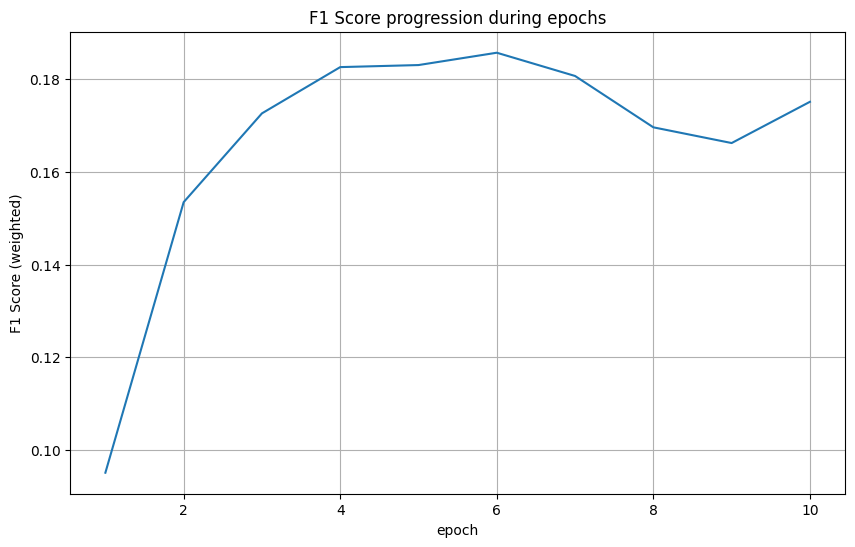

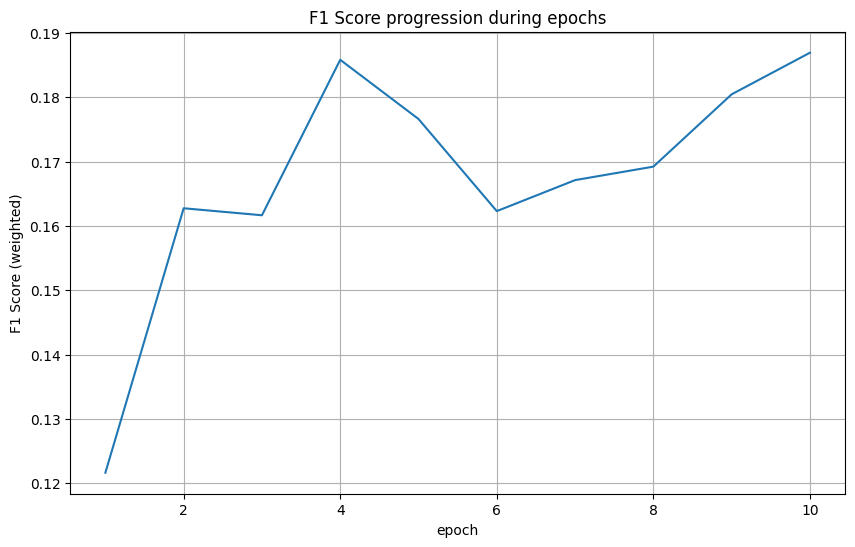

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


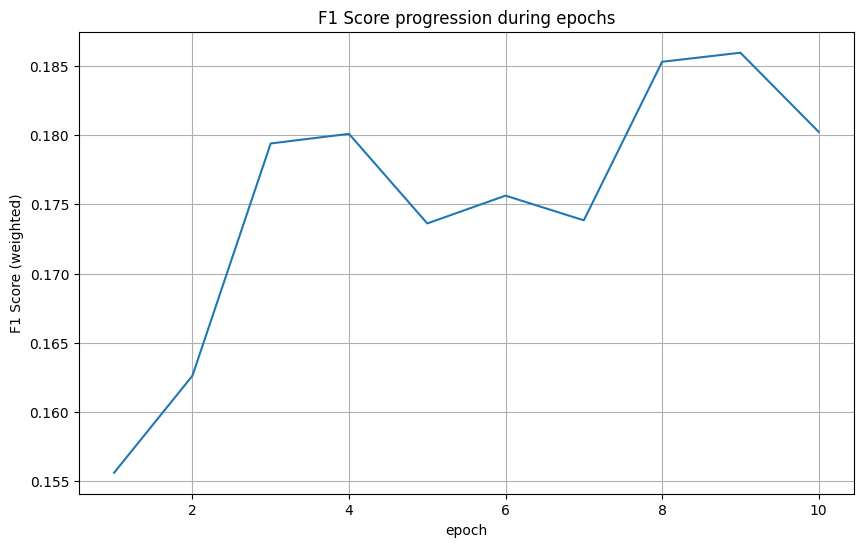

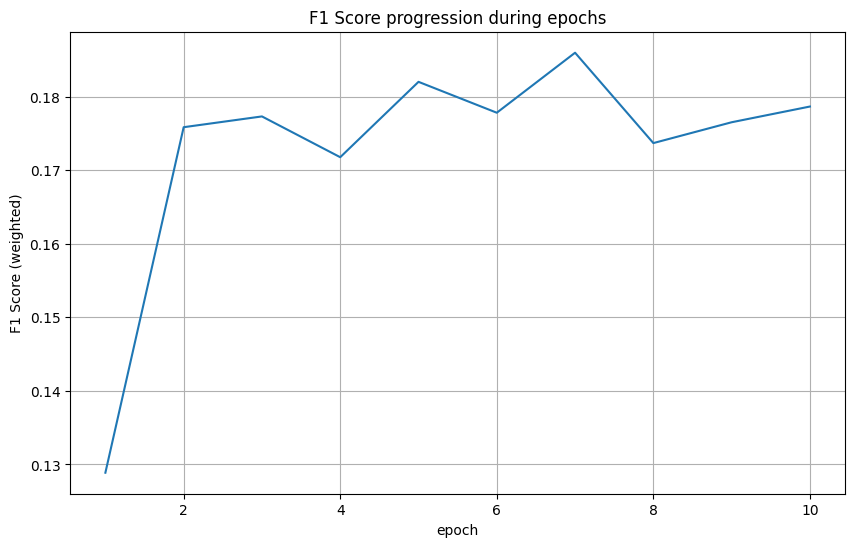

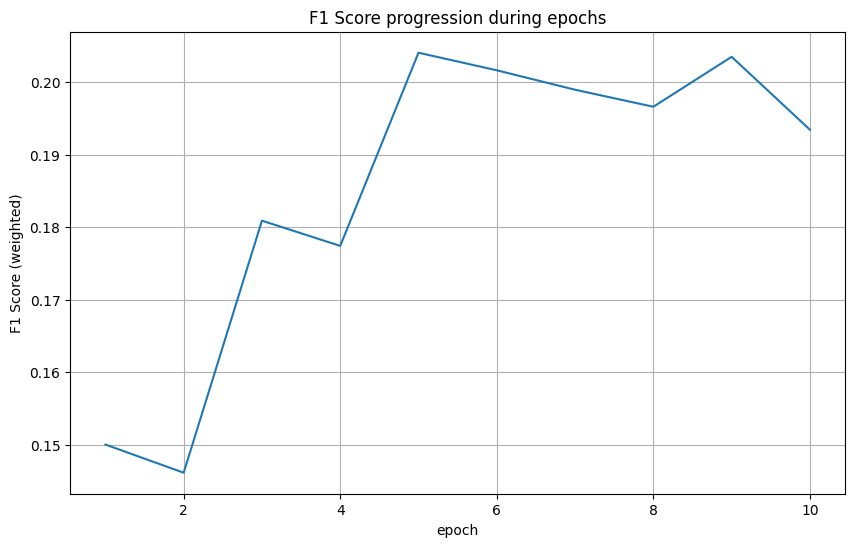

                                         model  hidden_size  n_layers  \
0   Baseline(predicting the most common class)          NaN       NaN   
1                                         LSTM         32.0       1.0   
2                                         LSTM         32.0       2.0   
3                                         LSTM         32.0       3.0   
4                                         LSTM         64.0       1.0   
..                                         ...          ...       ...   
68                                        LSTM         32.0       2.0   
69                                        LSTM         32.0       3.0   
70                                        LSTM         64.0       1.0   
71                                        LSTM         64.0       2.0   
72                                        LSTM         64.0       3.0   

    vocab_size  embed_dim  dropout  accuracy  precision    recall        f1  \
0          NaN        NaN      NaN  0.209155

In [78]:
true_labels = test['label'].values
word_vector_sizes = [32, 64]
hidden_sizes = [32, 64]
n_layers_list = [1, 2, 3]
dropouts = [0.2, 0.5, 0.8]
for dropout in dropouts:
  for size in word_vector_sizes:
      for hidden_size in hidden_sizes:
          for layers in n_layers_list:
            model = Net(vocab_size=vocab_size, word_vector_size=size, hidden_size=hidden_size, n_layers=layers, dropout = dropout)
            predictions = train_model(model)
            accuracy = accuracy_score(true_labels, predictions)
            precision = precision_score(true_labels, predictions, average='weighted')
            recall = recall_score(true_labels, predictions, average='weighted')
            f1 = f1_score(true_labels, predictions, average='weighted')
            append_results(report, model, accuracy, precision, recall, f1)
print(pd.DataFrame(report))

We should see which is the best model

In [79]:
def save_to_excel(report):
  df_results = pd.DataFrame(report)
  df_results.to_excel("model_results_report.xlsx", index=False)



In [89]:
train = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/test.csv")
valid = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake News Detection/data/valid.csv")
X_train_np, vocab_size = simple_tokenizer(train['statement'], max_len = 50)
X_valid_np, _ = simple_tokenizer(valid['statement'], max_len = 50)
X_test_np, _ = simple_tokenizer(test['statement'], max_len = 50)
train_loader = DataLoader(to_tensor(X_train_np, train['label']), batch_size=32, shuffle=False)
valid_loader = DataLoader(to_tensor(X_valid_np, valid['label']), batch_size=32)
test_loader = DataLoader(to_tensor(X_test_np, test['label']), batch_size=32)

In [ ]:
best_model = Net(vocab_size=5000, word_vector_size=64, hidden_size=32, n_layers=1, dropout = 0.5)
predictions = train_model(best_model)

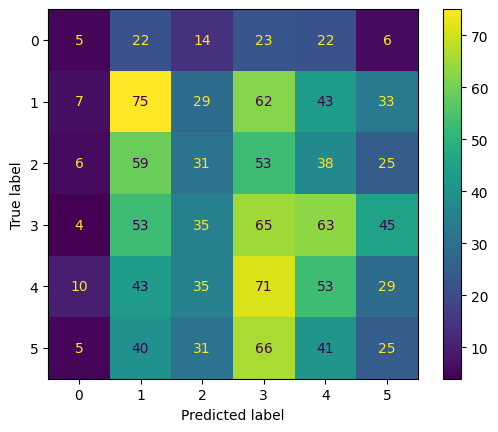

In [94]:
cm = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.show()